In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import optuna
from reservoirpy.observables import mse
from sklearn.preprocessing import RobustScaler
from optuna.visualization.matplotlib import (
    plot_slice,
    plot_contour,
    plot_param_importances,
)

from optuna_training import (
    ProcessedData,
    ModelConfiguration,
    get_3D_prediction_list,
    remove_warmup,
)
from optuna_post_processing import (
    get_predictions_dataframe,
    get_worst_individuals,
    plot_individual_results,
    get_statistics,
)

pd.options.display.max_rows = 20
pd.options.display.max_columns = 300

using a local optuna!


/home/francois/miniforge-pypy3/envs/reservoirs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [2]:
CSV_FILE = "../../data/synthetic_bph_1/Simulations/01_test.csv"

In [3]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data = data.sort_values(by=["individus", "temps"])
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,x2_x5,x4_x7,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,8.729390,8.605198,-6.255856,-6.144225,-2.996805,-2.991126,2.307527,2.279975,4.616573,4.615336,38.220878,38.163806,4.187466e+00,4.181621,0,-28.880618,9.662692e+00,-43.498706,-43.605232,-15.862629,-15.991621
1,1,1,9.075289,9.704948,-6.018428,-6.112985,-2.996020,-3.094470,2.252828,2.150593,2.317368,2.317199,39.248562,39.245740,3.712258e+00,3.709538,0,-13.946913,8.363078e+00,-20.211433,-20.401545,-7.797185,-7.829579
2,1,2,9.421187,9.596647,-5.879542,-5.801847,-2.993664,-2.938728,2.203334,2.420423,0.932058,0.930796,40.289880,40.332412,3.249134e+00,3.235153,0,-5.480074,7.158927e+00,-7.072602,-7.057319,-3.222236,-3.226070
3,1,3,9.767085,10.198744,-5.781001,-5.883516,-2.989738,-3.019894,2.158550,1.996865,0.334789,0.334388,41.344832,41.291154,2.808980e+00,2.806895,0,-1.935418,6.063324e+00,-1.653218,-1.594787,-1.304205,-1.367045
4,1,4,10.112983,9.873528,-5.704566,-5.616327,-2.984241,-2.908691,2.118027,1.878657,0.114954,0.113111,42.413417,42.368055,2.400529e+00,2.400502,0,-0.655763,5.084385e+00,0.223129,0.180240,-0.609093,-0.547249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-2.462644,-2.583611,-1.008648,-1.005435,-3.012749,-3.218416,1.540358,1.520395,7.755539,7.756008,52.689242,52.714643,9.081671e-09,0.003654,1,-7.822612,1.398902e-08,1.100055,0.990910,-4.453522,-4.409573
12996,500,22,-2.972811,-3.602696,-0.961010,-0.870865,-3.008361,-3.028149,1.553460,1.607670,7.756674,7.756364,53.279452,53.282305,3.401095e-09,-0.003304,1,-7.454240,5.283465e-09,1.047838,1.071853,-4.254718,-4.326941
12997,500,23,-3.482978,-2.910034,-0.915399,-0.987839,-3.003769,-3.071758,1.565315,1.596924,7.757462,7.756919,53.872949,53.850949,1.273714e-09,-0.002870,1,-7.101176,1.993764e-09,0.997791,0.990856,-4.064175,-4.332440
12998,500,24,-3.993145,-3.816640,-0.871651,-0.968017,-2.998973,-2.887558,1.576042,1.661724,7.758010,7.759375,54.469734,54.366824,4.770072e-10,-0.007898,1,-6.762277,7.517835e-10,0.949751,0.920250,-3.881277,-3.802191


In [4]:
SERIES_COLUMN_NAME = "individus"
TIMESTEPS_COLUMN_NAME = "temps"

Formula for `y_fixed` and `y_mixed` (data/synthetic_bph_1/model_oracle_regular_time.R):

```R
g_fixed <- mvrnorm(length(ind), µg, diag(numeric(3)))
df$y_fixed <- g_fixed[df$individus, 1] + 
              g_fixed[df$individus, 2] * df$x2 * df$x5 + 
              g_fixed[df$individus, 3] * df$x4 * df$x7

g_mixed <- mvrnorm(length(ind), µg, diag(c(0.5, 0.5, 0.05)))
df$y_mixed <- g_mixed[df$individus, 1] +
              g_mixed[df$individus, 2] * df$x2 * df$x5 +
              g_mixed[df$individus, 3] * df$x4 * df$x7
```


So:   
$y_{fixed}(t) = f(x_2(t), x_5(t), x_4(t), x_7(t))$
$y_{mixed}(t, i) = f(x_2(t), x_5(t), x_4(t), x_7(t), \gamma_{i,25}, )$

# Summary

## Objective

Study the capacity of Reservoir Computing (RC) to model longitudinal health data with mixed effects.  

In other word: do the modelisation of complex time dependecies can compensate the lack of direct modelisation of the random effect?


## Method

### Sub-studies

The study is done in incremental steps, starting from this baseline:
- fixed effects target, without noise
- using the "oracle" features: $x_2 * x_5$, $x_4 * x_7$

Then we'll see the effect of:
- addding noise on the target
- using the mixed effect target
- using the real features ($x_1, …, x_7$)

For each sub-study we'll do a **capacity** test, training *and* predicting on the same data, to see if the model can learn the data.  
If successful, we'll do a **generalization** test, with a train/test split.  

### Hyper-parameters optimization

From *Unsupervised Reservoir Computing for Solving Ordinary Differential Equations*:  
> Training an RC is efficient, however, finding the optimal hyper-parameters that determine the weight distributions and the network architecture is challenging. RC performance strongly depends on these hyper-parameters and, therefore, finding good hyper-parameters is crucial. The RC has many hyper-parameters making this a computationally expensive process.


We will use Optuna for the hyper-parameters optimization.

**trial**: set of hyperparameters suggested by Optuna   
**warmup**: first timesteps that are ignore in the computation of the loss and error


**The method**:
```
for each trial:
    for 5 random seeds:
        generate the reservoir
        train the reservoir
        predict using the reservoir
        compute the MSE: MSE_seed 
    compute MSE_trial = mean(MSE_seed)
return the best trial corresponding to min(MSE_trial)
```


**Note on Optuna's TPESampler**:  

https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html  
> Sampler using TPE (Tree-structured Parzen Estimator) algorithm.  
On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) $l(x)$ to the set of parameter values associated with the best objective values, and another GMM $g(x$) to the remaining parameter values. It chooses the parameter value x that maximizes the ratio $l(x)/g(x)$.


https://anna-ssi.github.io/blog/tpe/  
> Tree-structured Parzen Estimators (TPE) derive their name from the **combination of Parzen estimators to model the probability distributions of hyperparameters and a structured, graph-like approach to represent hyperparameter configurations**. In this tree-like representation, each hyperparameter is a node, and edges denote the dependencies between them.  
For example, the choice of the optimizer (e.g., Adam) and the learning rate can be seen as interconnected nodes.  
This structured representation allows TPE to focus on updating only the relevant parts of the model when new observations are made.  
It also facilitates establishing **dependencies among random variables**, making conditional sampling more efficient and enabling the algorithm to optimize the search space faster.


# Objective function for Optuna





In [5]:
N_WARMUPS = 3
N_SEEDS = 5
N_CPUS = 2

In [6]:
# https://reservoirpy.readthedocs.io/en/latest/user_guide/hyper.html#Optimize-hyperparameters


def get_model_list(trial, x_labels):
    reservoir_kwargs = {
        "units": trial.suggest_int("N", 50, 5000),
        # "sr": trial.suggest_float("sr", 1e-2, 1e1, log=True),
        "sr": trial.suggest_float("sr", 1e-3, 1e1, log=True),
        # "lr": trial.suggest_float("lr", 1e-3, 1e0, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 1e0, log=True),
        # SUPER! tu as décalé l'indice de l'input_scaling avec celui du x correspondant <3
        "input_scaling": [
            trial.suggest_float(f"input_scaling_{i}", 1e-5, 1e2, log=True)
            for i, _ in enumerate(x_labels)
        ],
    }

    ridge_kwargs = {
        #  "ridge": trial.suggest_float("ridge", 1e-8, 1e1, log=True),
        "ridge": trial.suggest_float("ridge", 1e-10, 1e2, log=True),
    }

    fit_kwargs = {
        "warmup": N_WARMUPS,
    }

    return [
        ModelConfiguration(
            input_kwargs={},
            reservoir_kwargs=reservoir_kwargs,
            ridge_kwargs=ridge_kwargs,
            fit_kwargs=fit_kwargs,
            input_to_readout=trial.suggest_categorical(
                "input_to_readout", [True, False]
            ),
            readout_feedback_to_reservoir=trial.suggest_categorical(
                "readout_feedback_to_reservoir", [True, False]
            ),
        )
        for reservoir_kwargs["seed"] in range(42, 42 + N_SEEDS)
    ]

In [7]:
def optuna_objective(trial, processed_data):

    model_list = get_model_list(trial, processed_data.x_labels)
    list_mse = [
        mse(
            remove_warmup(processed_data.y_test_3D, N_WARMUPS),
            remove_warmup(y_hat_3D, N_WARMUPS),
        )
        for y_hat_3D in get_3D_prediction_list(
            model_list, processed_data, n_cpus=N_CPUS
        )
    ]
    return np.mean(list_mse)

# Baseline => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target without random effects

In [8]:
STUDY_NAME = "Cheat-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_fixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.


[I 2024-11-13 15:34:17,774] Using an existing study with name 'Cheat-Capacity' instead of creating a new one.



229 trials found.

The best model MSE is: 8.62e-26


## Predictions of the best model

In [9]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Statistics of the predictions

In [10]:
# get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

### Worst individual predictions of the best model

In [11]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17020/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

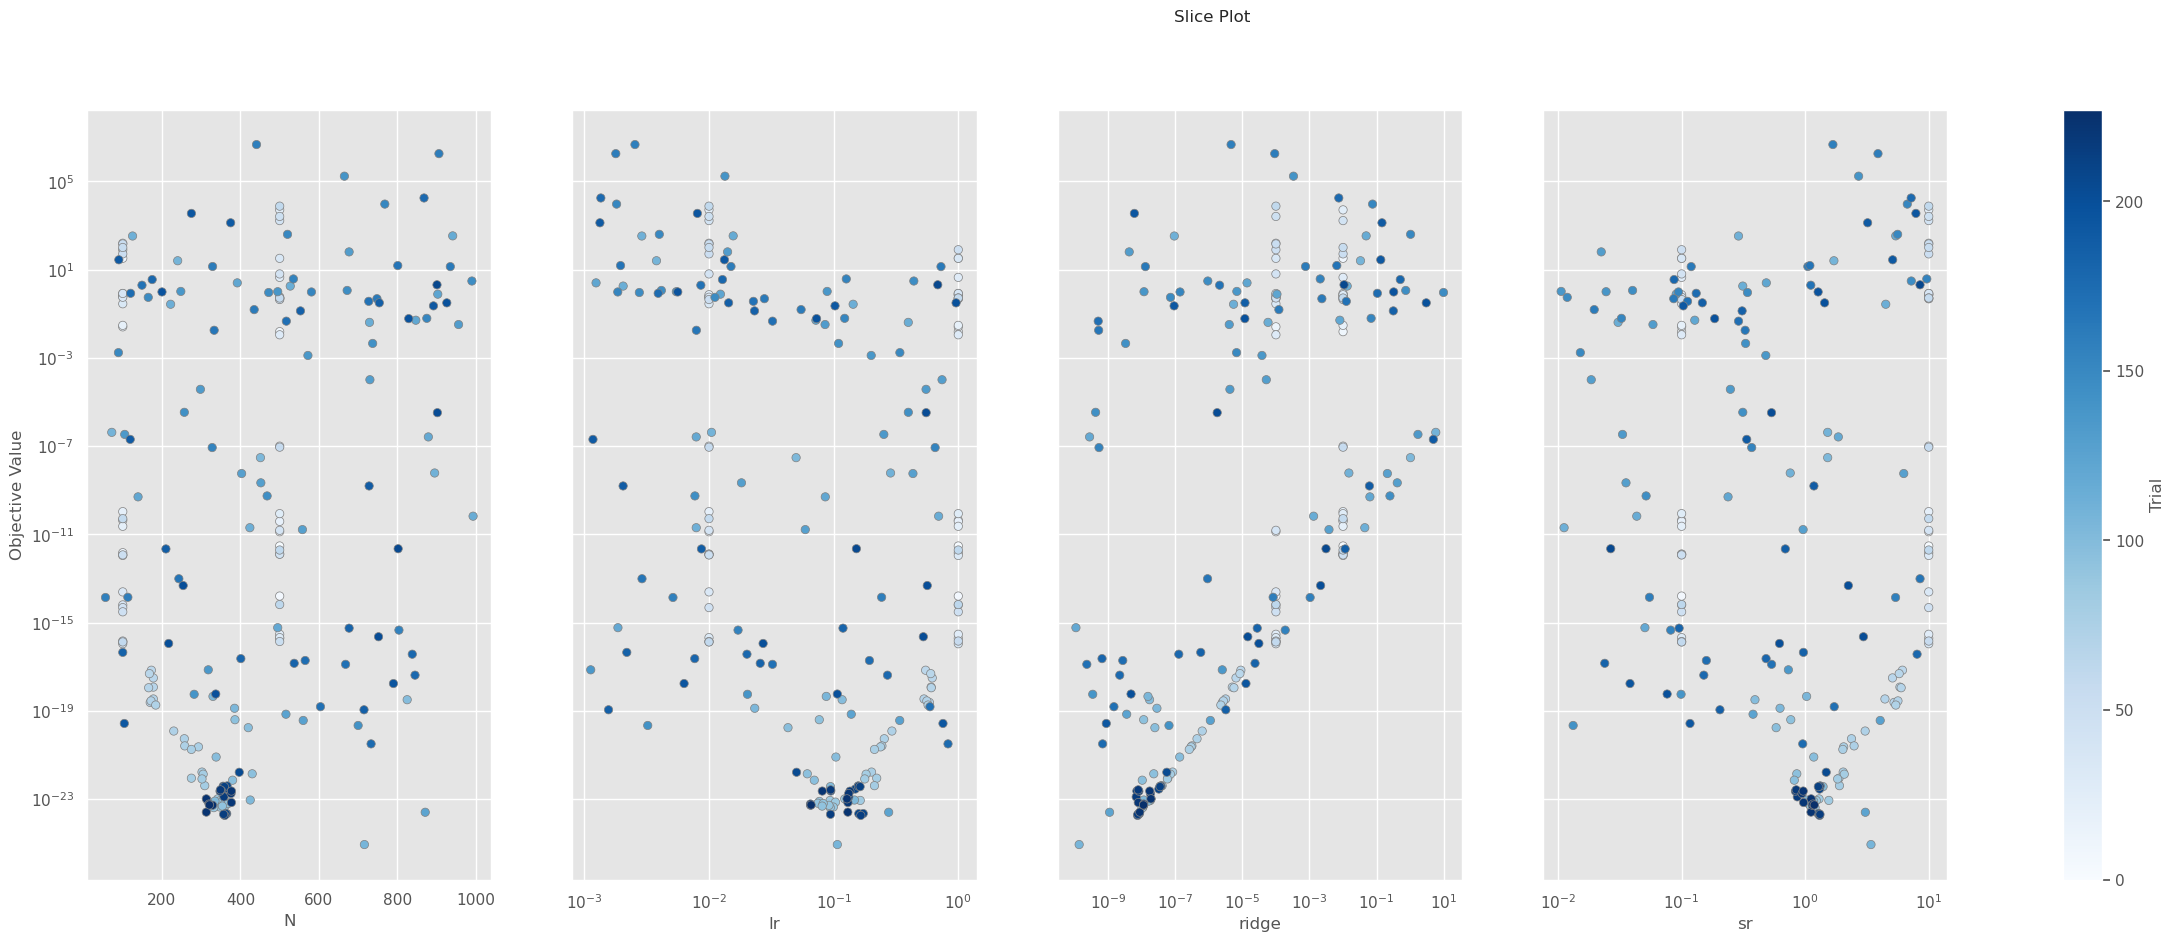

In [12]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

# Baseline => Generalization 

In [13]:
STUDY_NAME = "Cheat-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = ["y_fixed"]
y_labels_test = ["y_fixed"]


indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:20,367] Using an existing study with name 'Cheat-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

179 trials found.

The best model MSE is: 1.03e-23


## Predictions of the best model

In [14]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Statistics of the predictions

In [15]:
# get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

### Worst individual predictions of the best model

In [16]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17020/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


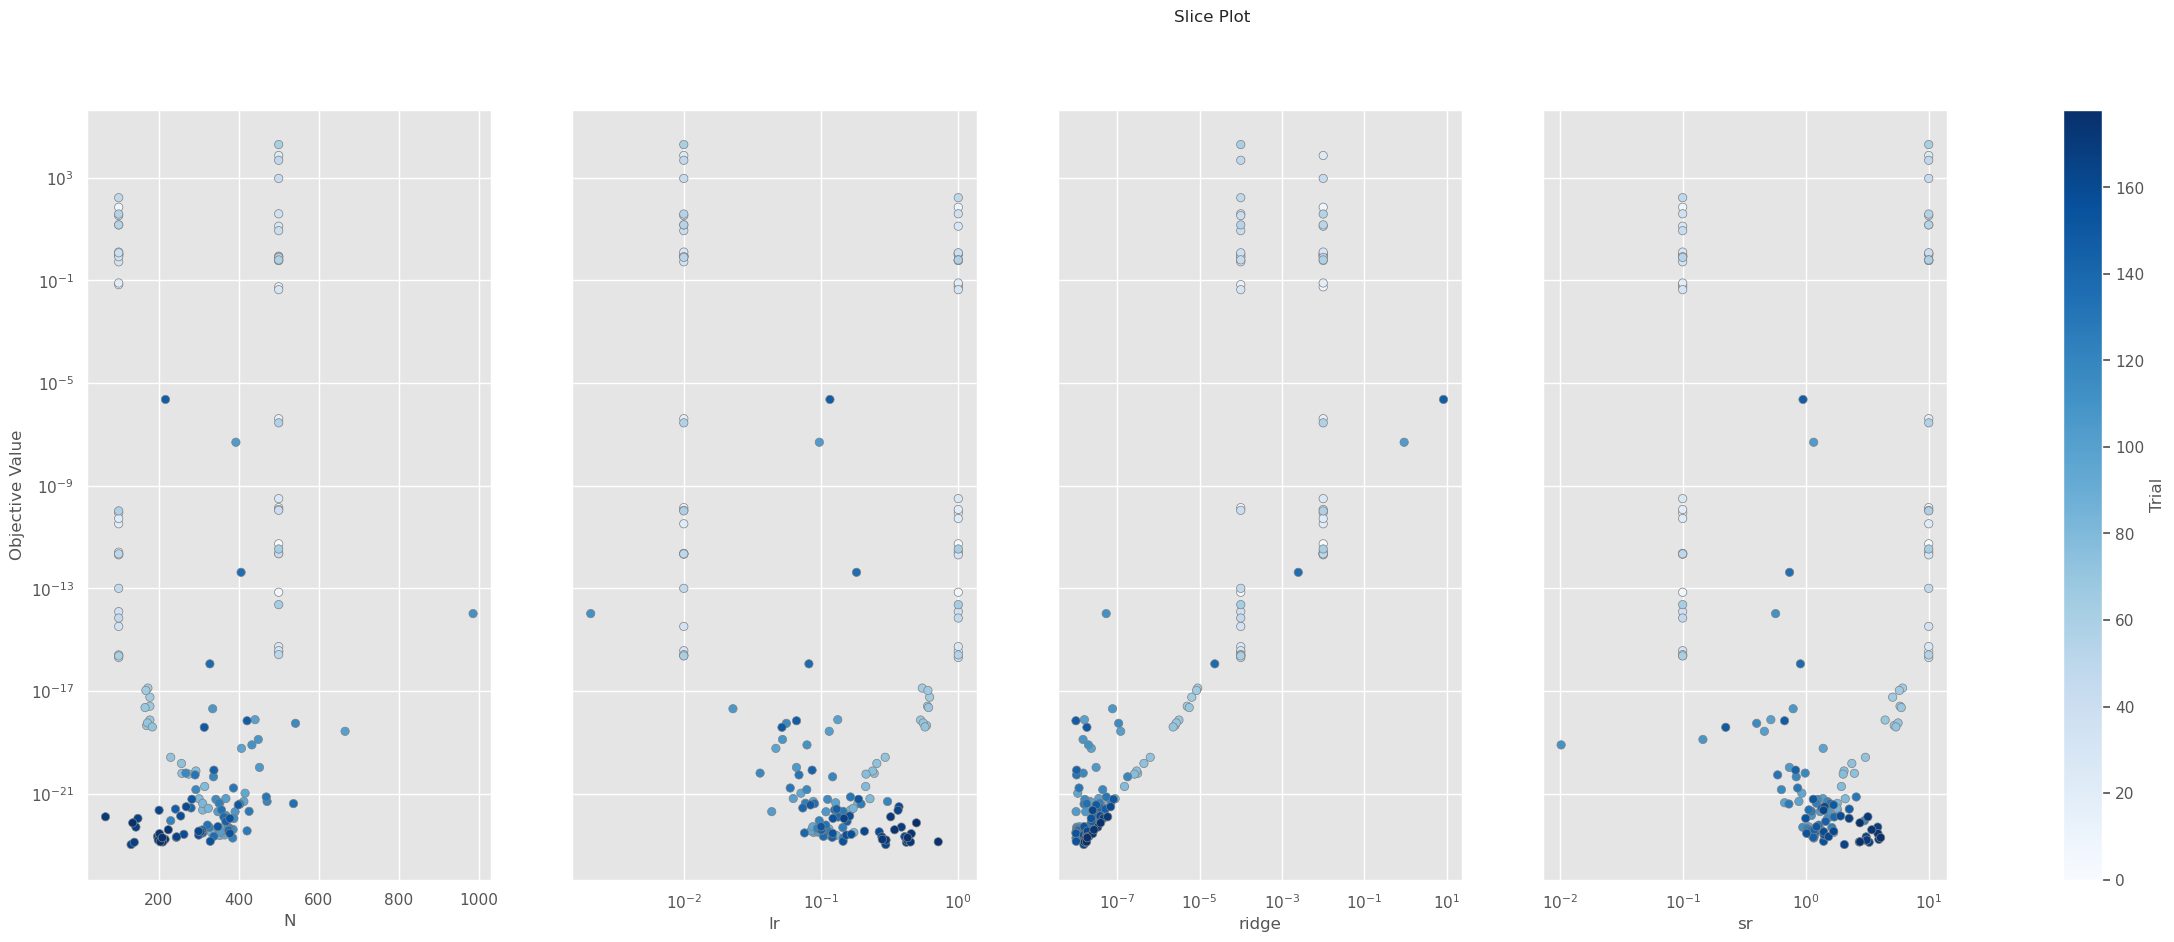

In [17]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

# Baseline + noise on target > Generalization

In [18]:
STUDY_NAME = "Cheat-Noisy-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = ["y_fixed_obs"]
y_labels_test = ["y_fixed"]


indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:22,645] Using an existing study with name 'Cheat-Noisy-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

181 trials found.

The best model MSE is: 1.34e-08


## Predictions of the best model

In [19]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Statistics of the predictions

In [20]:
# get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

### Worst individual predictions of the best model

In [21]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17020/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


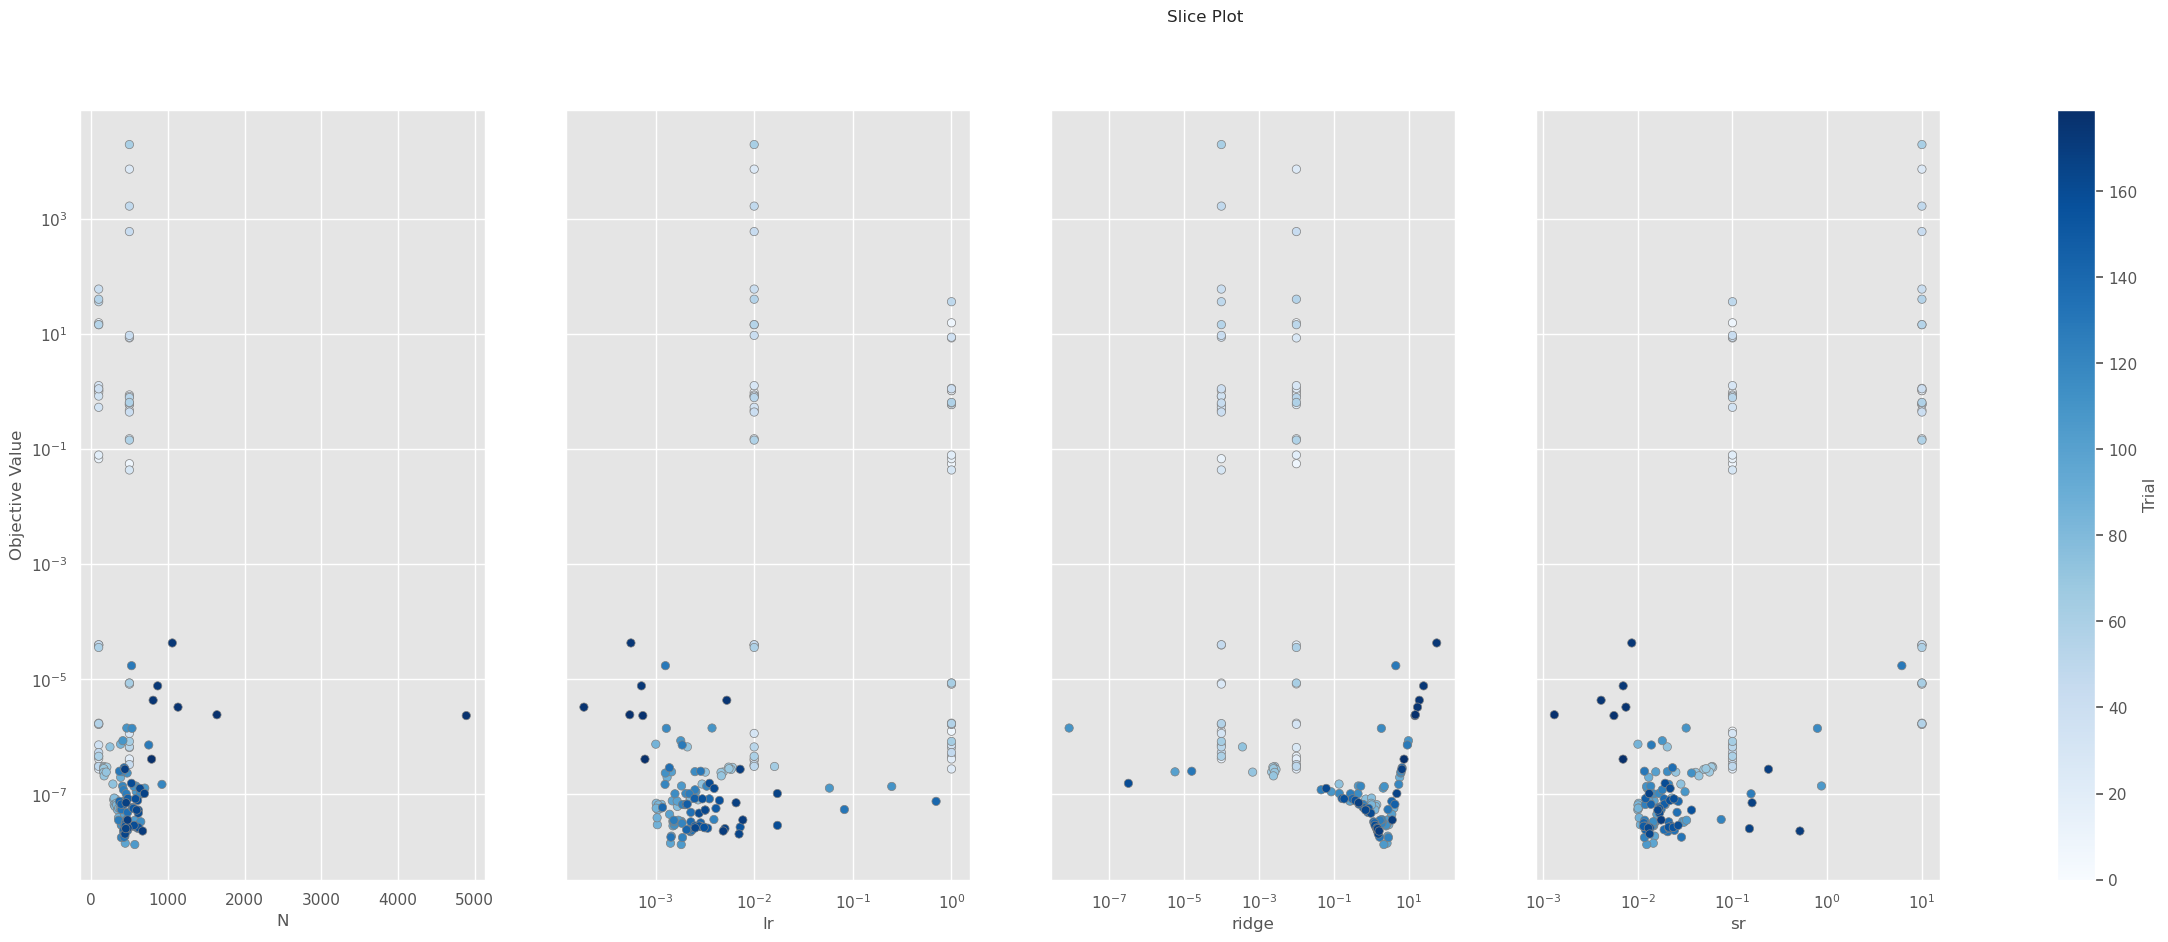

In [22]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

# Baseline + Mixed effects => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target with random effects

In [23]:
STUDY_NAME = "MixedEffect-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_mixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

# #######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
# ######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:25,145] Using an existing study with name 'MixedEffect-Capacity' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

401 trials found.

The best model MSE is: 3.42e-02


## Predictions of the best model

In [24]:
if Path(df_name).exists() and (
    Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
):
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
else:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
    df_pred.to_pickle(df_name)

'MixedEffect-Capacity.pkl' opened


### Statistics of the predictions

	MAE: 0.49157979005027674
	MSE: 1.1646741144850459


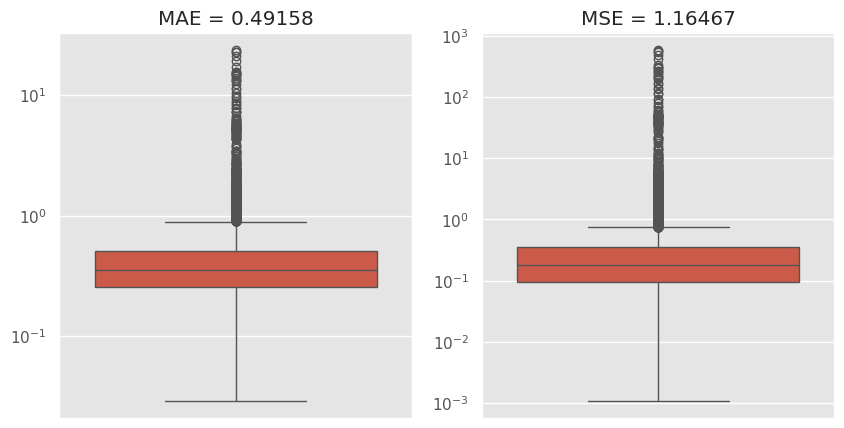

In [25]:
get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

In [ ]:
YOUHOU!

### Worst individual predictions of the best model

Returning the 2 worst MAE individuals (mean over seeds and timesteps).


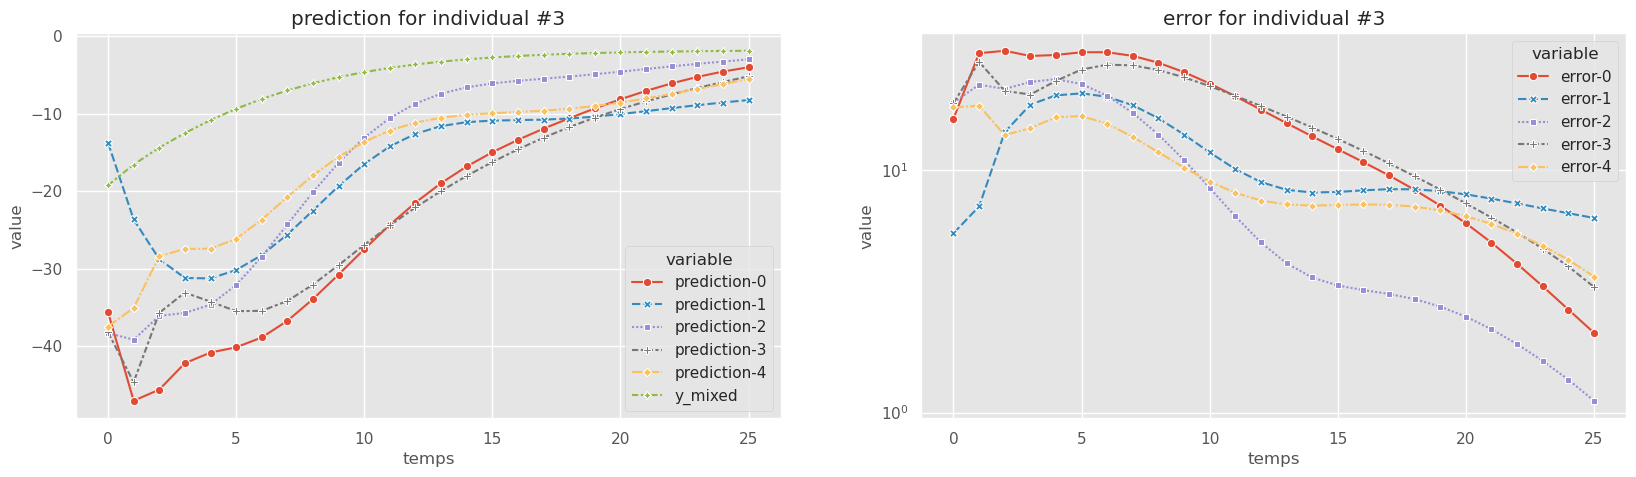

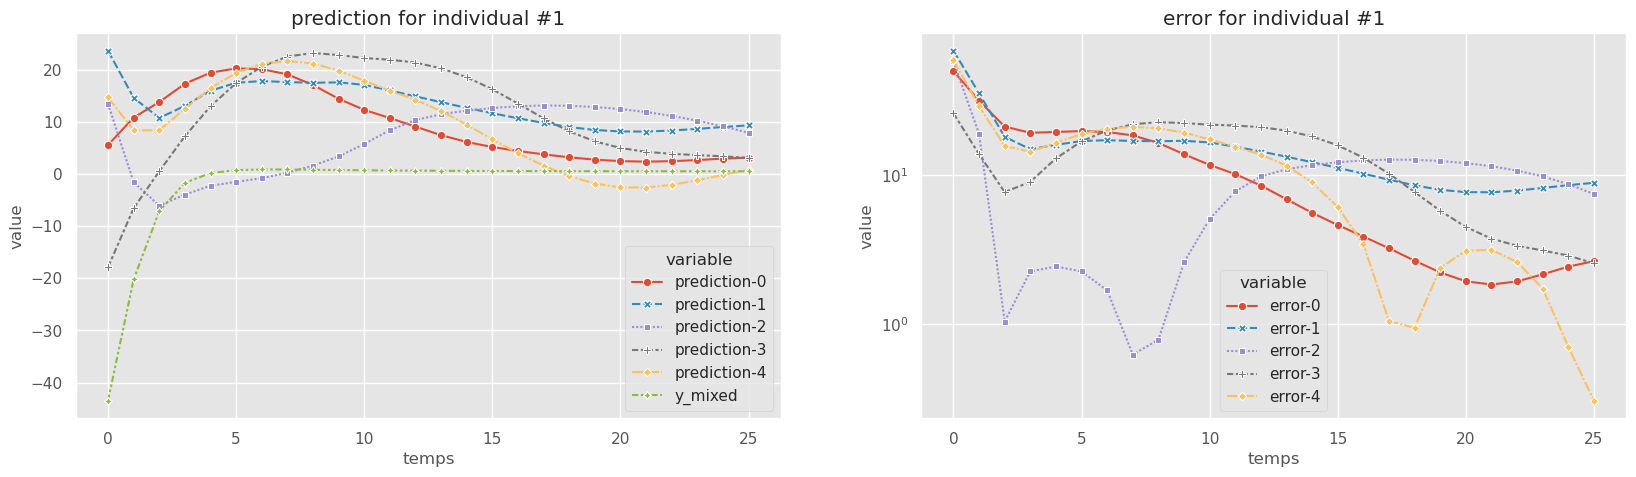

In [26]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

## Hyper-parameters analysis

/tmp/ipykernel_17020/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


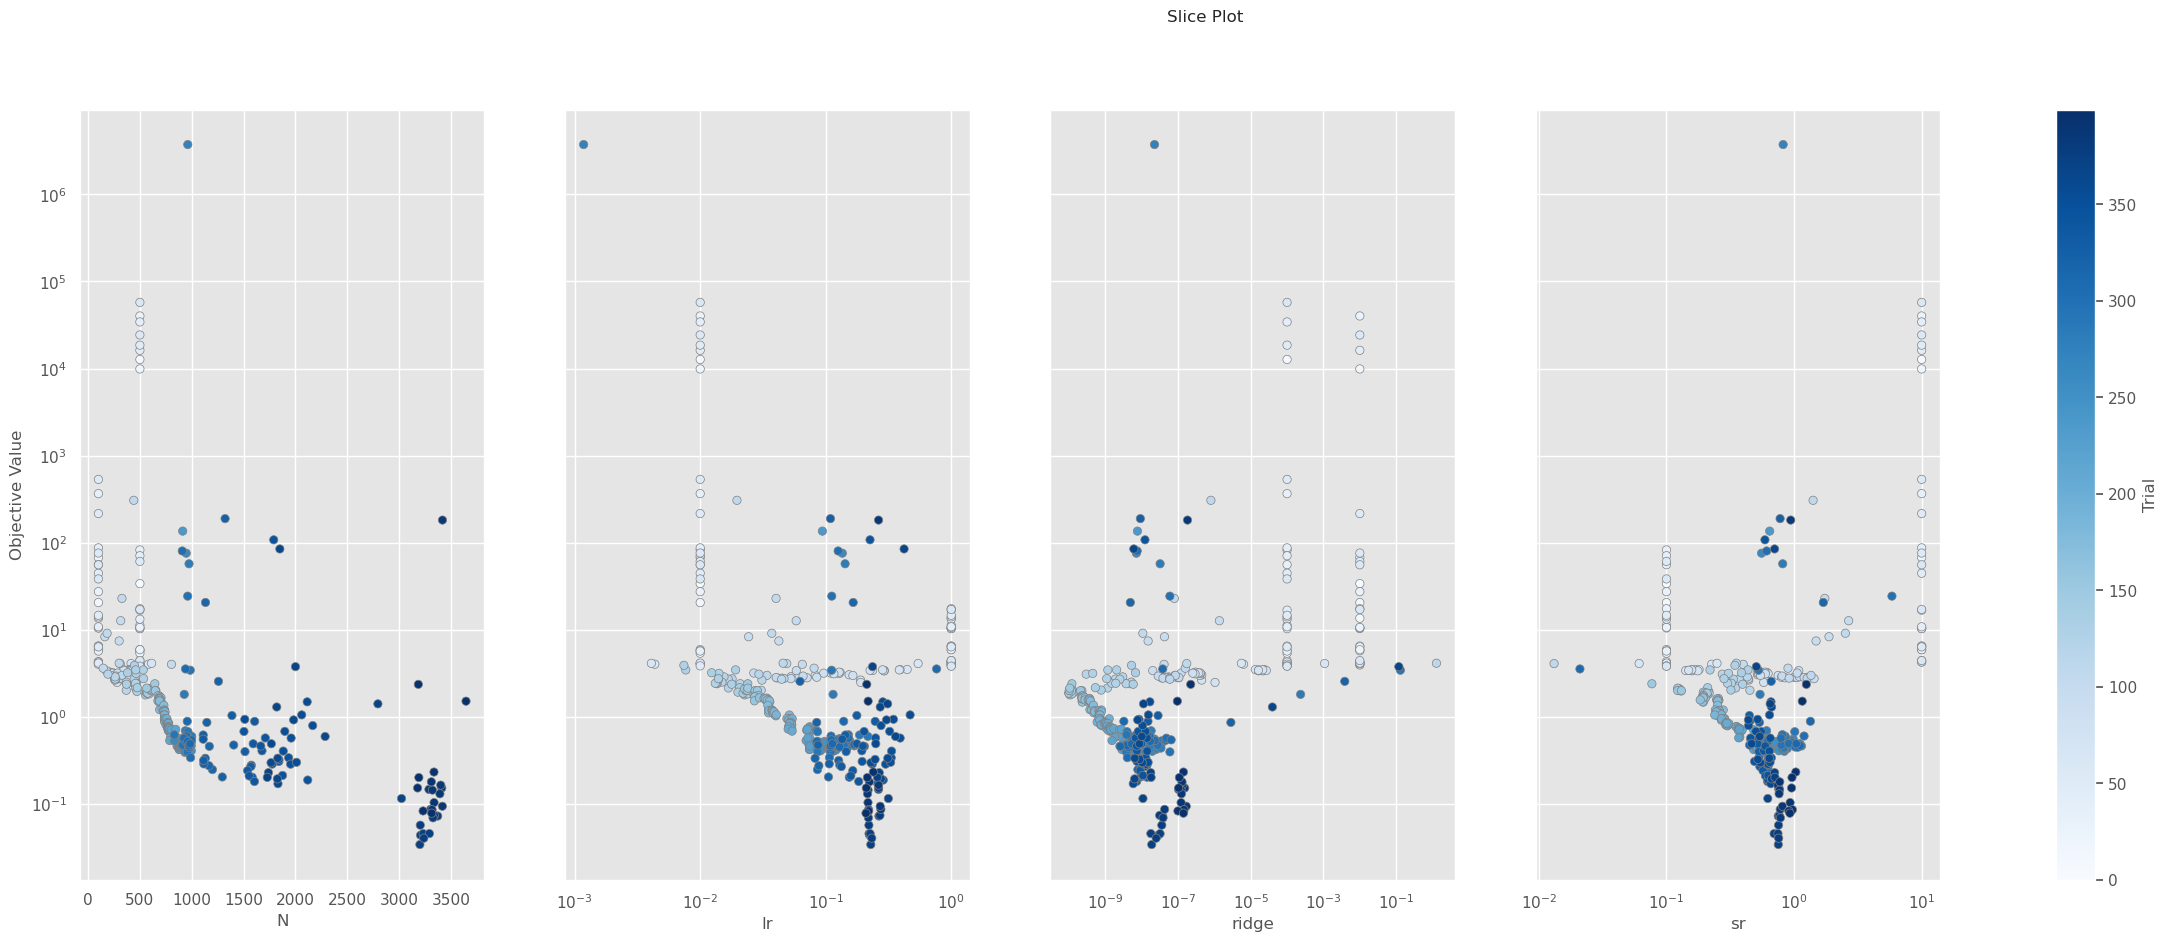

In [27]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

# Baseline + Mixed effects => Generalization

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target with random effects

In [28]:
STUDY_NAME = "MixedEffect-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = y_labels_test = ["y_mixed"]

indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]


processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

# #######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
# ######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:31,431] Using an existing study with name 'MixedEffect-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

200 trials found.

The best model MSE is: 8.01e+00


## Predictions of the best model

In [29]:
if Path(df_name).exists() and (
    Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
):
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
else:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
    df_pred.to_pickle(df_name)

'MixedEffect-Generalization.pkl' opened


### Statistics of the predictions

	MAE: 8.141647544706116
	MSE: 249.54257565670227


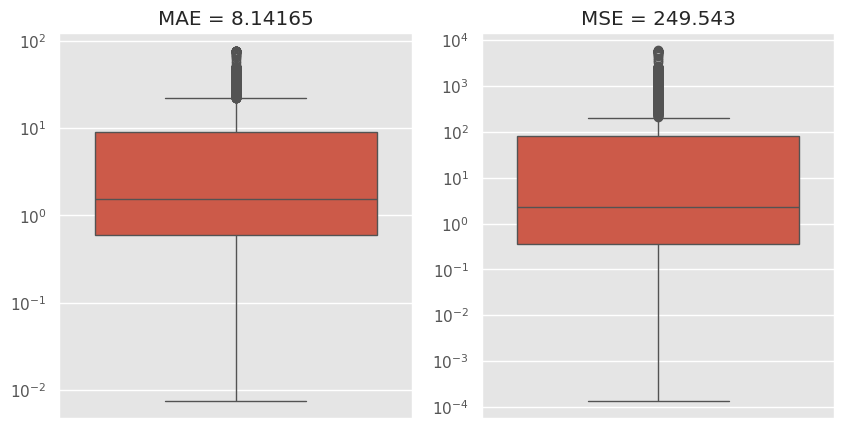

In [30]:
get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

### Worst individual predictions of the best model

Returning the 2 worst MAE individuals (mean over seeds and timesteps).


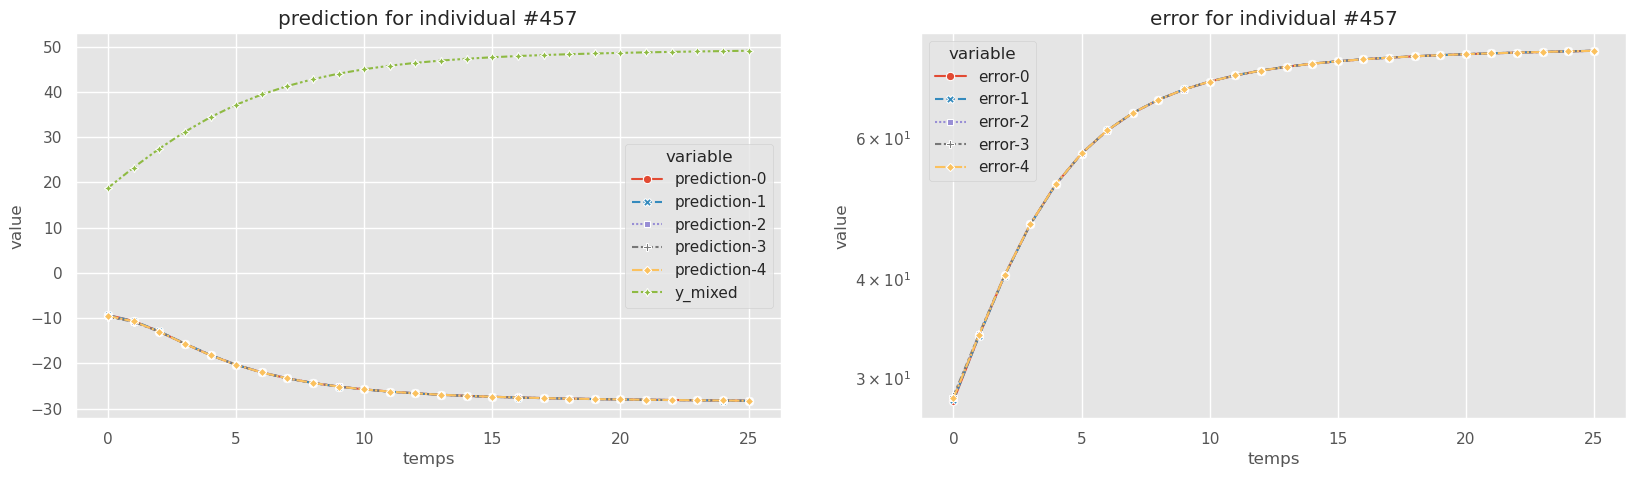

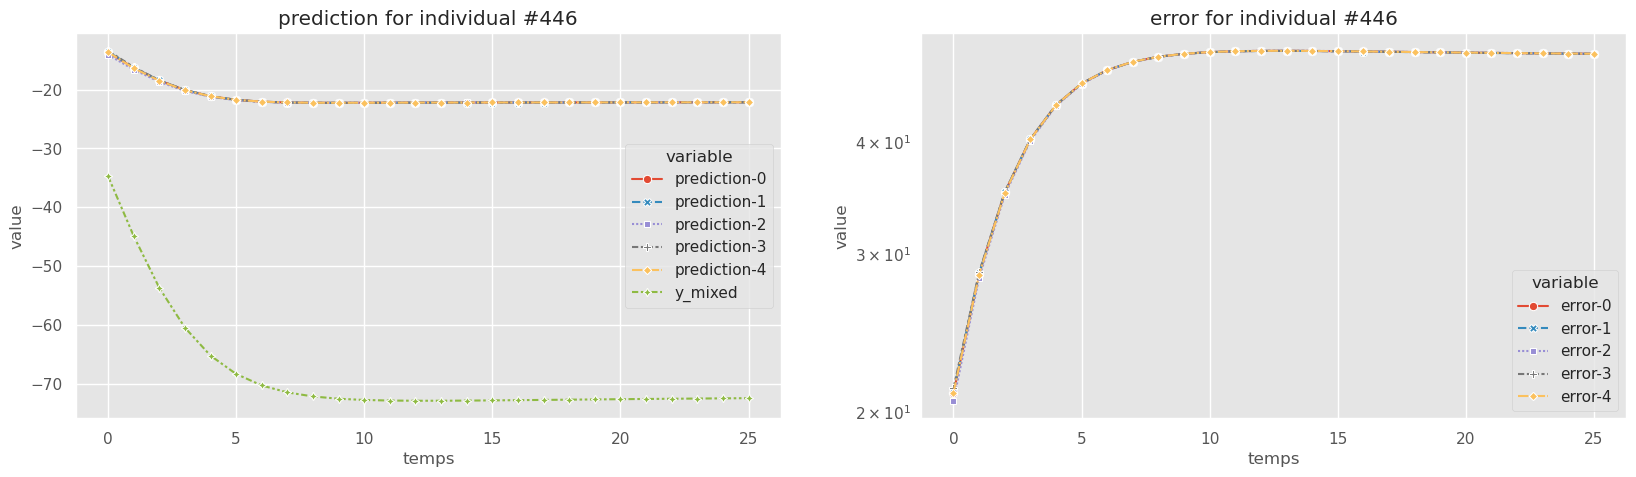

In [31]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

## Hyper-parameters analysis

/tmp/ipykernel_17020/2948150441.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


(2.851293461717257, 1000.0)

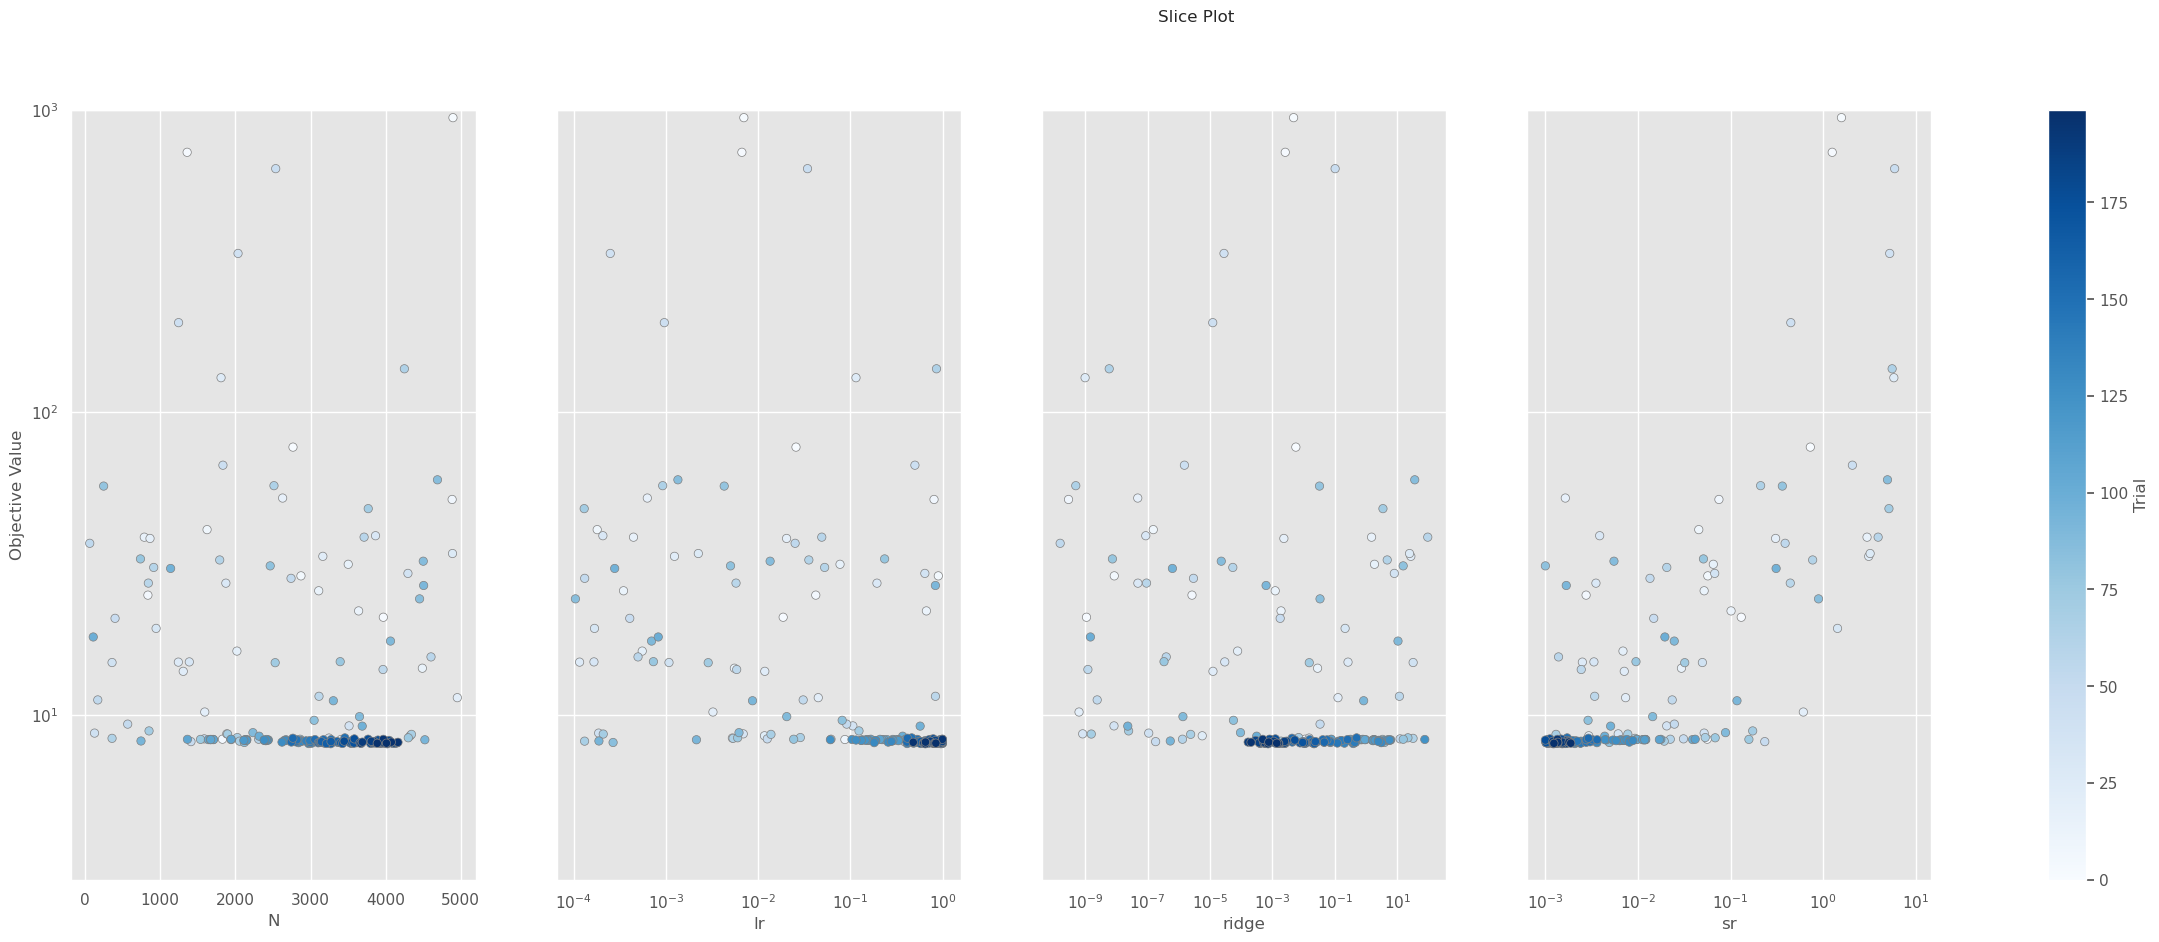

In [32]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim(top=1e3)

# Baseline + Random effects only => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- random effects

In [33]:
# STUDY_NAME =s "RandomEffect-Capacity"
# db_name = f"{STUDY_NAME}.db"
# df_name = f"{STUDY_NAME}.pkl"
# # %rm "$db_name"
# storage_name = f"sqlite:///{db_name}"

# x_labels = ["x2_x5", "x4_x7"]
# data["y_rand"] = data["y_mixed"] - data["y_fixed"]
# data_train = data_test = data
# y_labels_train = y_labels_test = ["y_rand"]

# processed_data = ProcessedData(
#     data_train,
#     data_test,
#     SERIES_COLUMN_NAME,
#     TIMESTEPS_COLUMN_NAME,
#     x_labels,
#     y_labels_train,
#     y_labels_test,
#     RobustScaler(),
# )

# study = optuna.create_study(
#     study_name=STUDY_NAME,
#     storage=storage_name,
#     directions=["minimize"],
#     load_if_exists=True,
# )

# if not study.trials:

#     study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
#     study.optimize(
#         lambda x: optuna_objective(x, processed_data),
#         n_trials=100,
#     )

# #######################
# # study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# # study.optimize(
# #     lambda x: optuna_objective(x, processed_data),
# #     n_trials=100,
# # )
# ######################

# print(f"\n{len(study.trials)} trials found.")

# print(f"\nThe best model MSE is: {study.best_value:.2e}")

## Predictions of the best model

In [34]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Statistics of the predictions

In [35]:
# get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

### Worst individual predictions of the best model

In [36]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

In [37]:
# axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
# ax = axes[0]
# ax.set_yscale("log")
# ax.set_ylim(top=1e4)

# All numerical features => Capacity

We use:
- features:
  - all numerical features, so ($x_1, ..., x_7$) **but not** $x_8$
  - without noise
- target without random effects

In [38]:
STUDY_NAME = "all-numerical-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_fixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:37,440] Using an existing study with name 'all-numerical-Capacity' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

480 trials found.

The best model MSE is: 3.09e-07


## Predictions of the best model

In [39]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Statistics of the predictions

In [40]:
# get_statistics(df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS)

### Worst individual predictions of the best model

In [41]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17020/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


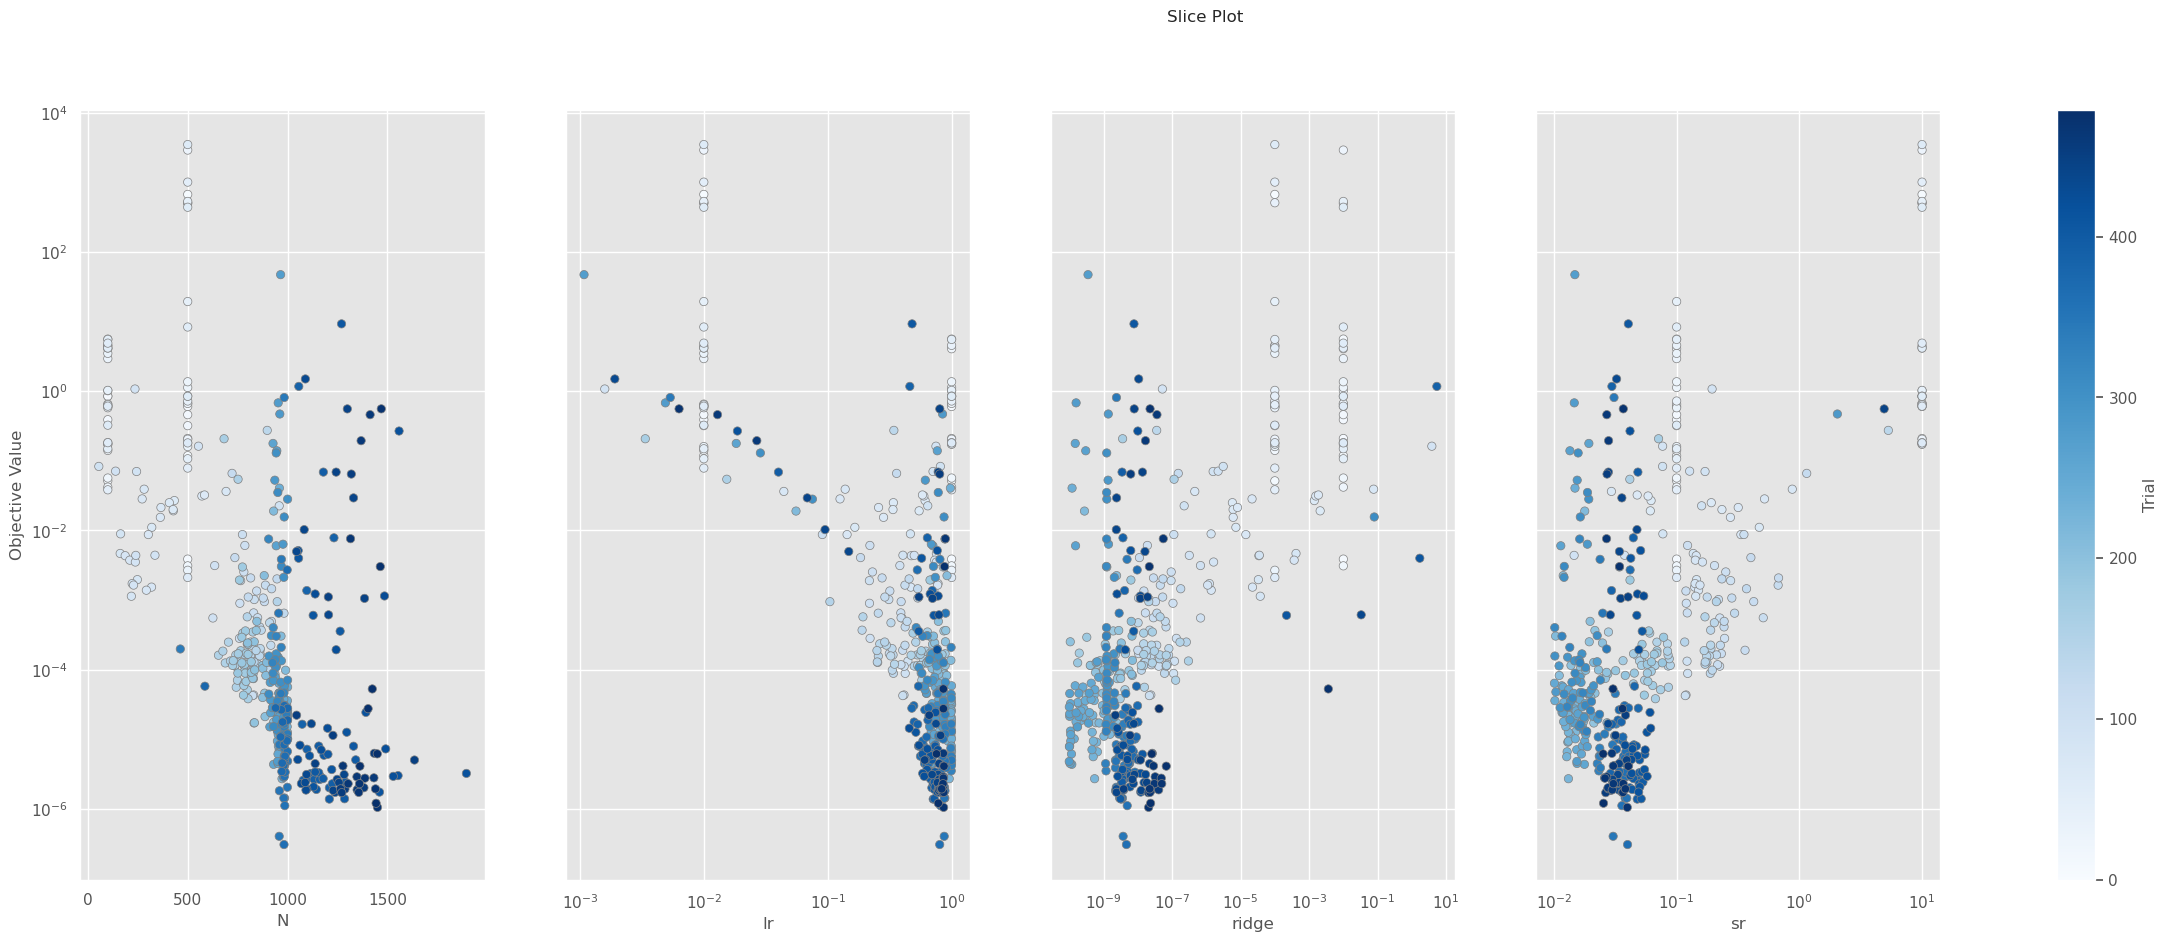

In [42]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

We check if the HP optimization helps selecting the informative variables.

These input scalings should be high:

/tmp/ipykernel_17020/1735128556.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(


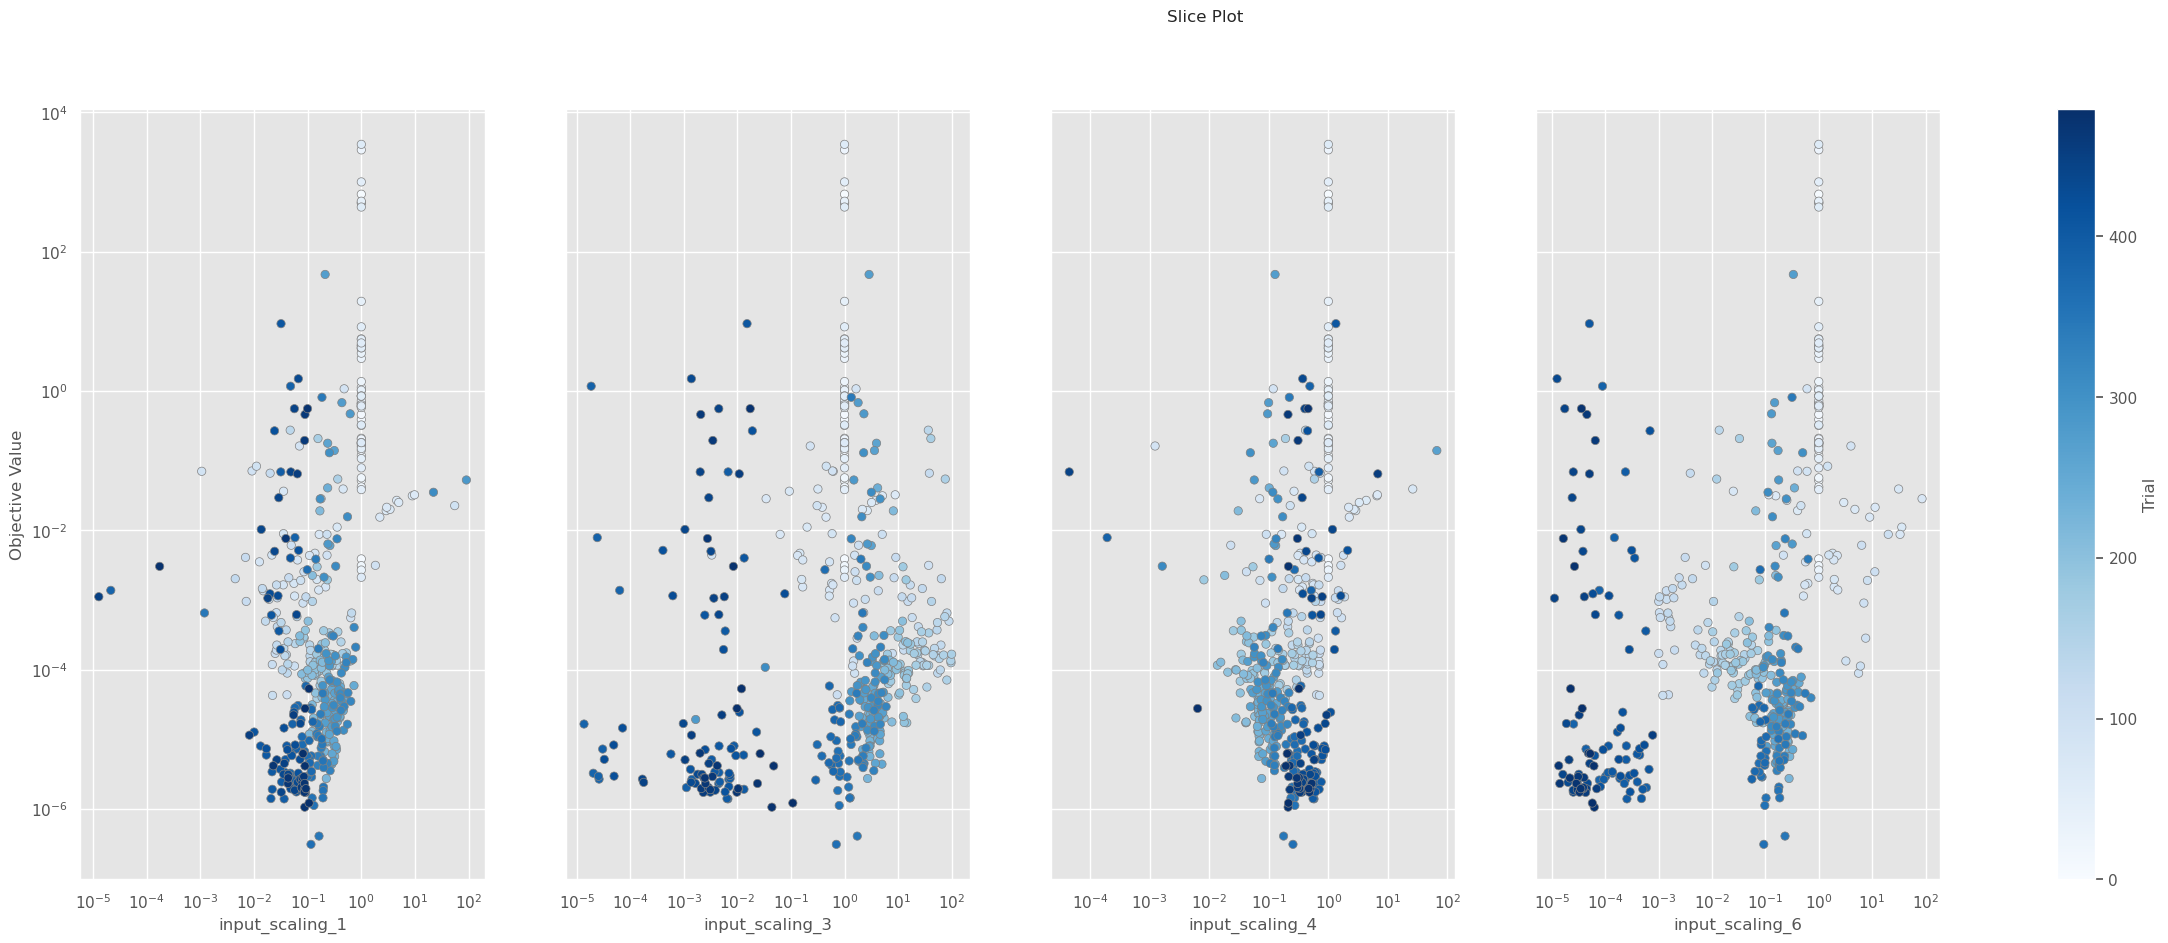

In [43]:
# "x2_x5" and "x4_x7"

axes = plot_slice(
    study,
    params=[
        # "input_scaling_0", # x1
        "input_scaling_1",  # x2
        # "input_scaling_2", # x3
        "input_scaling_3",  # x4
        "input_scaling_4",  # x5
        # "input_scaling_5", # x6
        "input_scaling_6",  # x7
    ],
)
ax = axes[0]
ax.set_yscale("log")

These input scalings should be low:

/tmp/ipykernel_17020/3483984188.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(


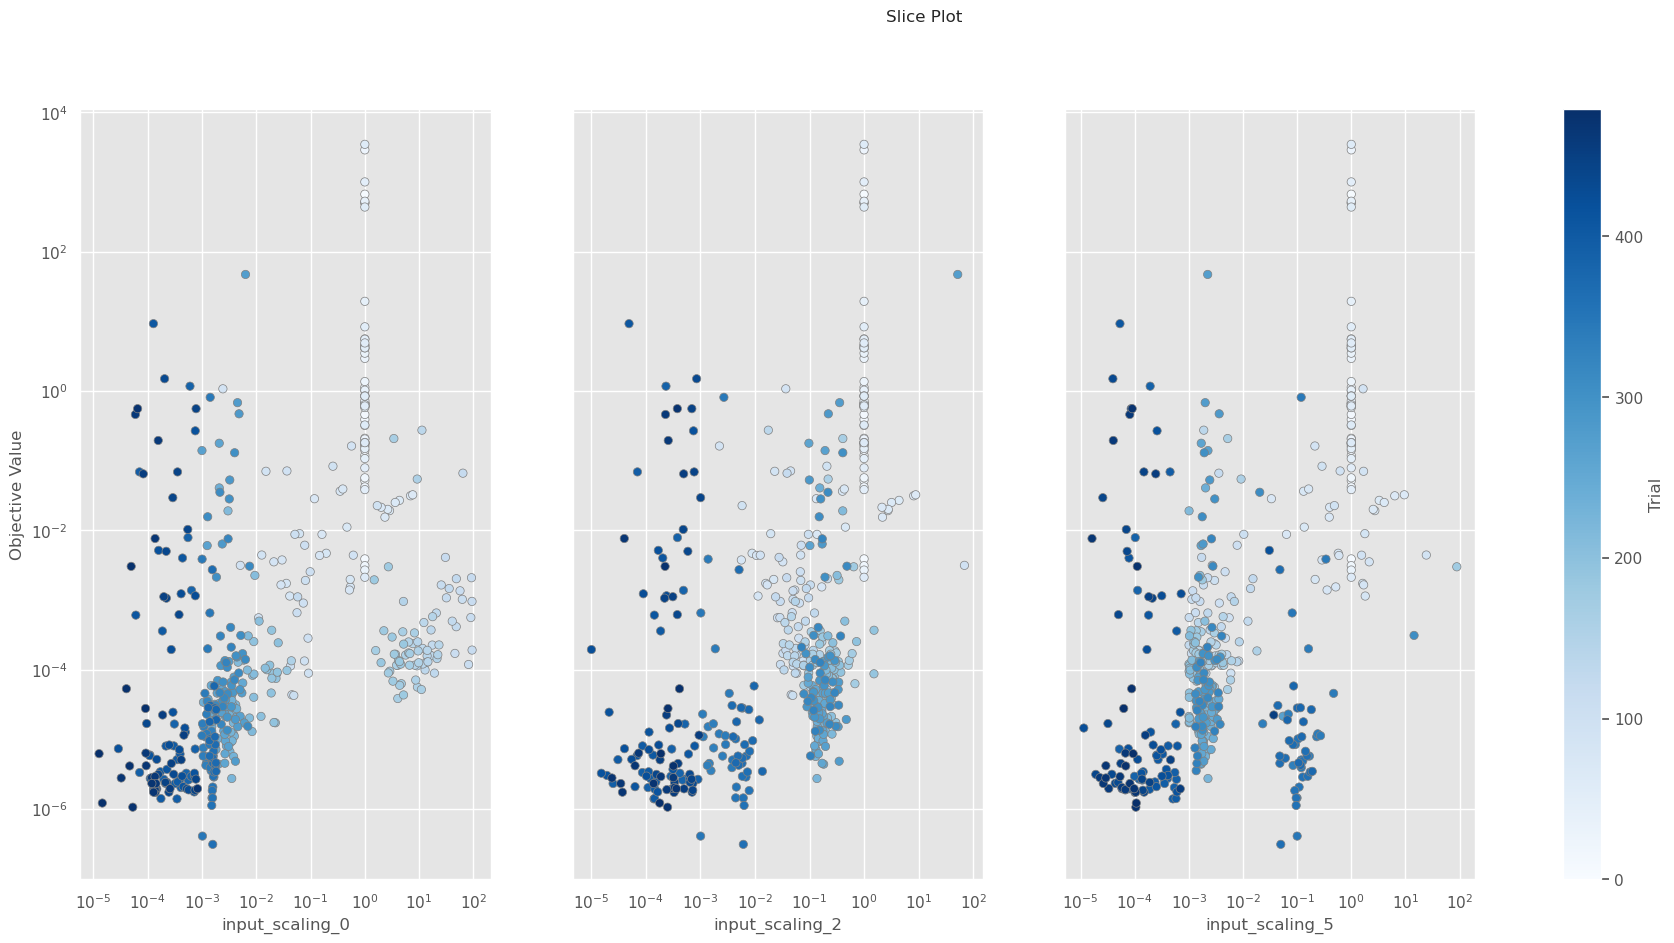

In [44]:
axes = plot_slice(
    study,
    params=[
        "input_scaling_0",  # x1
        # "input_scaling_1", # x2
        "input_scaling_2",  # x3
        # "input_scaling_3", # x4
        # "input_scaling_4", # x5
        "input_scaling_5",  # x6
        # "input_scaling_6", # x7
    ],
)
ax = axes[0]
ax.set_yscale("log")

There is a tendecy:  
- $1e^{-1}$  for usefull feature  
- $1e^{-3}$  for useless features (… excetp $x_6$ / input_scaling_5)

# Summary

In [45]:
# ls *.db

In [46]:
studies_titles = {
    # "Baseline: Capacity": "Cheat-Capacity",
    "Baseline: Generalization": "Cheat-Generalization",
    "Baseline + Noisy Target": "Cheat-Noisy-Generalization",
    "Baseline + Mixed Effects: Capacity": "MixedEffect-Capacity",
    "Baseline + Mixed Effects: Generalization": "MixedEffect-Generalization",
    # "Baseline + Random Effects: Capacity": "RandomEffect-Capacity",
    "All Num. Features: Capacity": "all-numerical-Capacity",
}

/tmp/ipykernel_17020/9884751.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
/tmp/ipykernel_17020/9884751.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
/tmp/ipykernel_17020/9884751.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
/tmp/ipykernel_17020/9884751.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
/tmp/ipykernel_17020/9884751.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes 

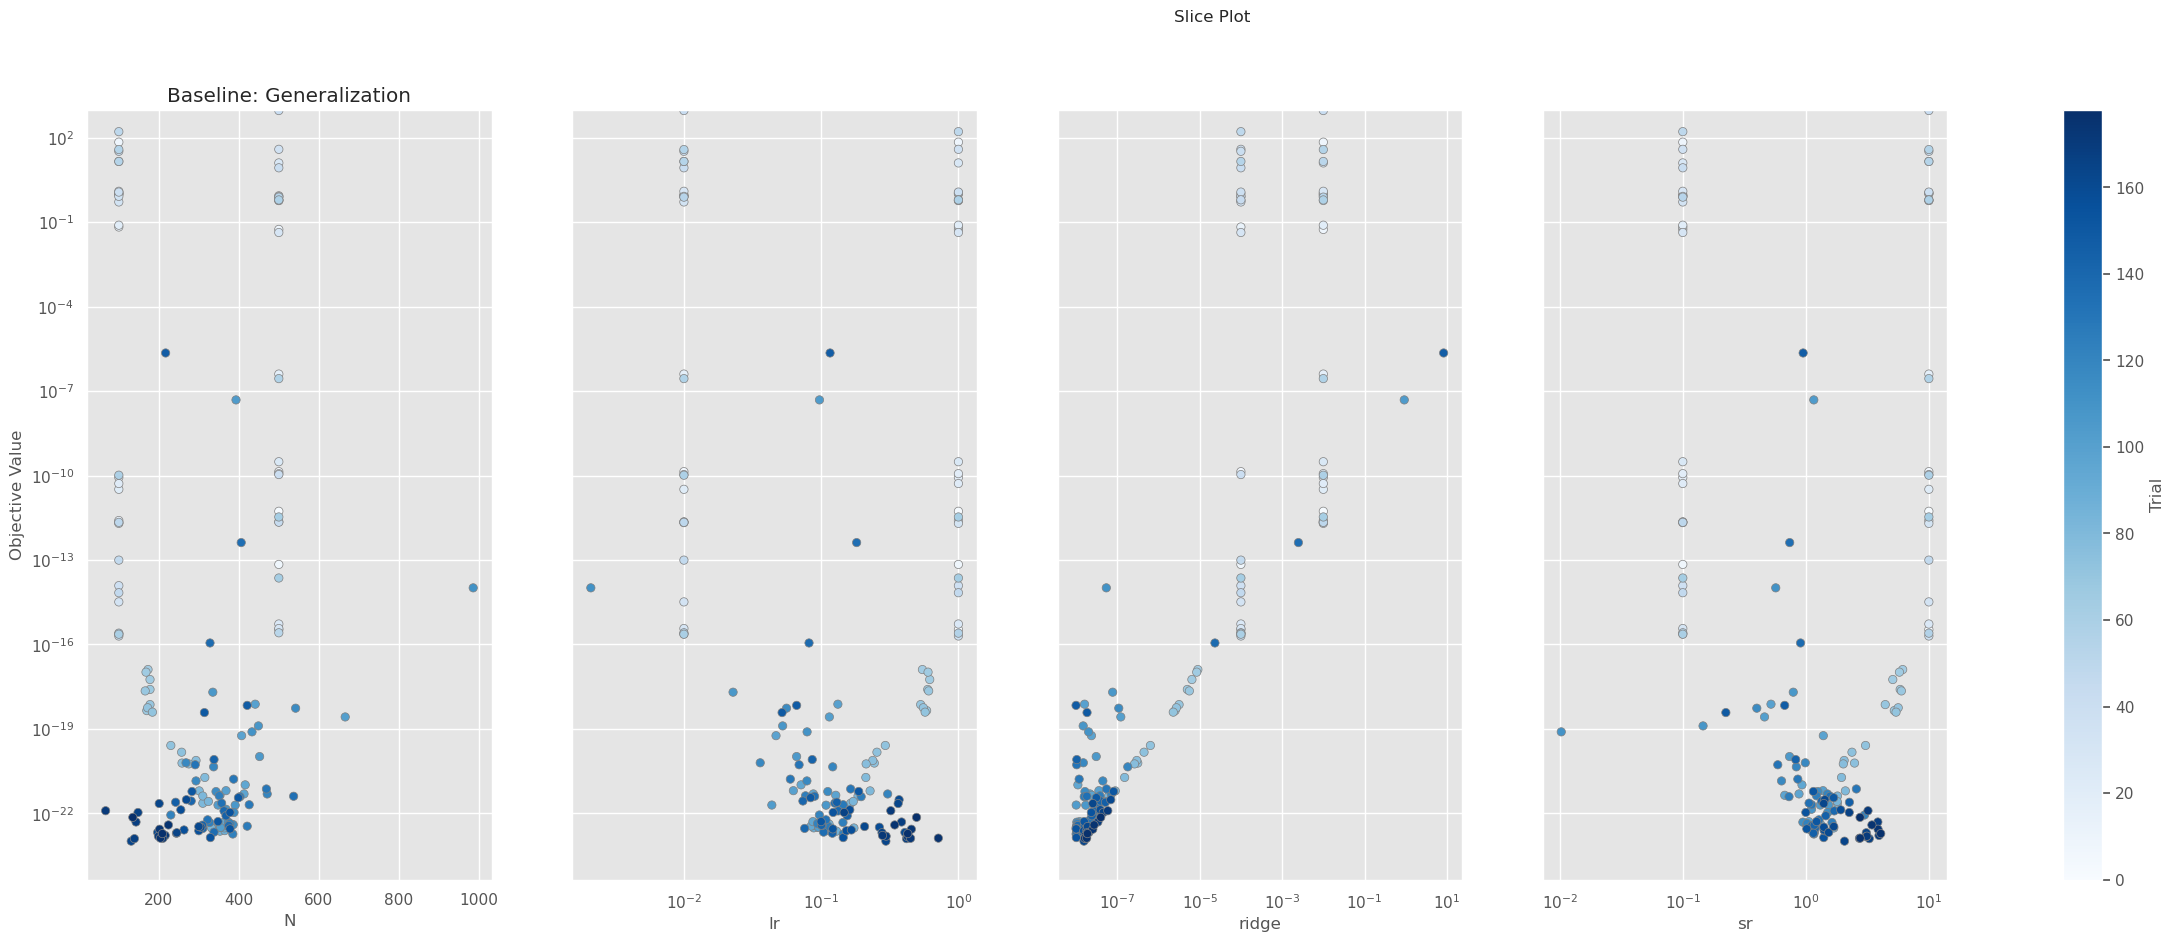

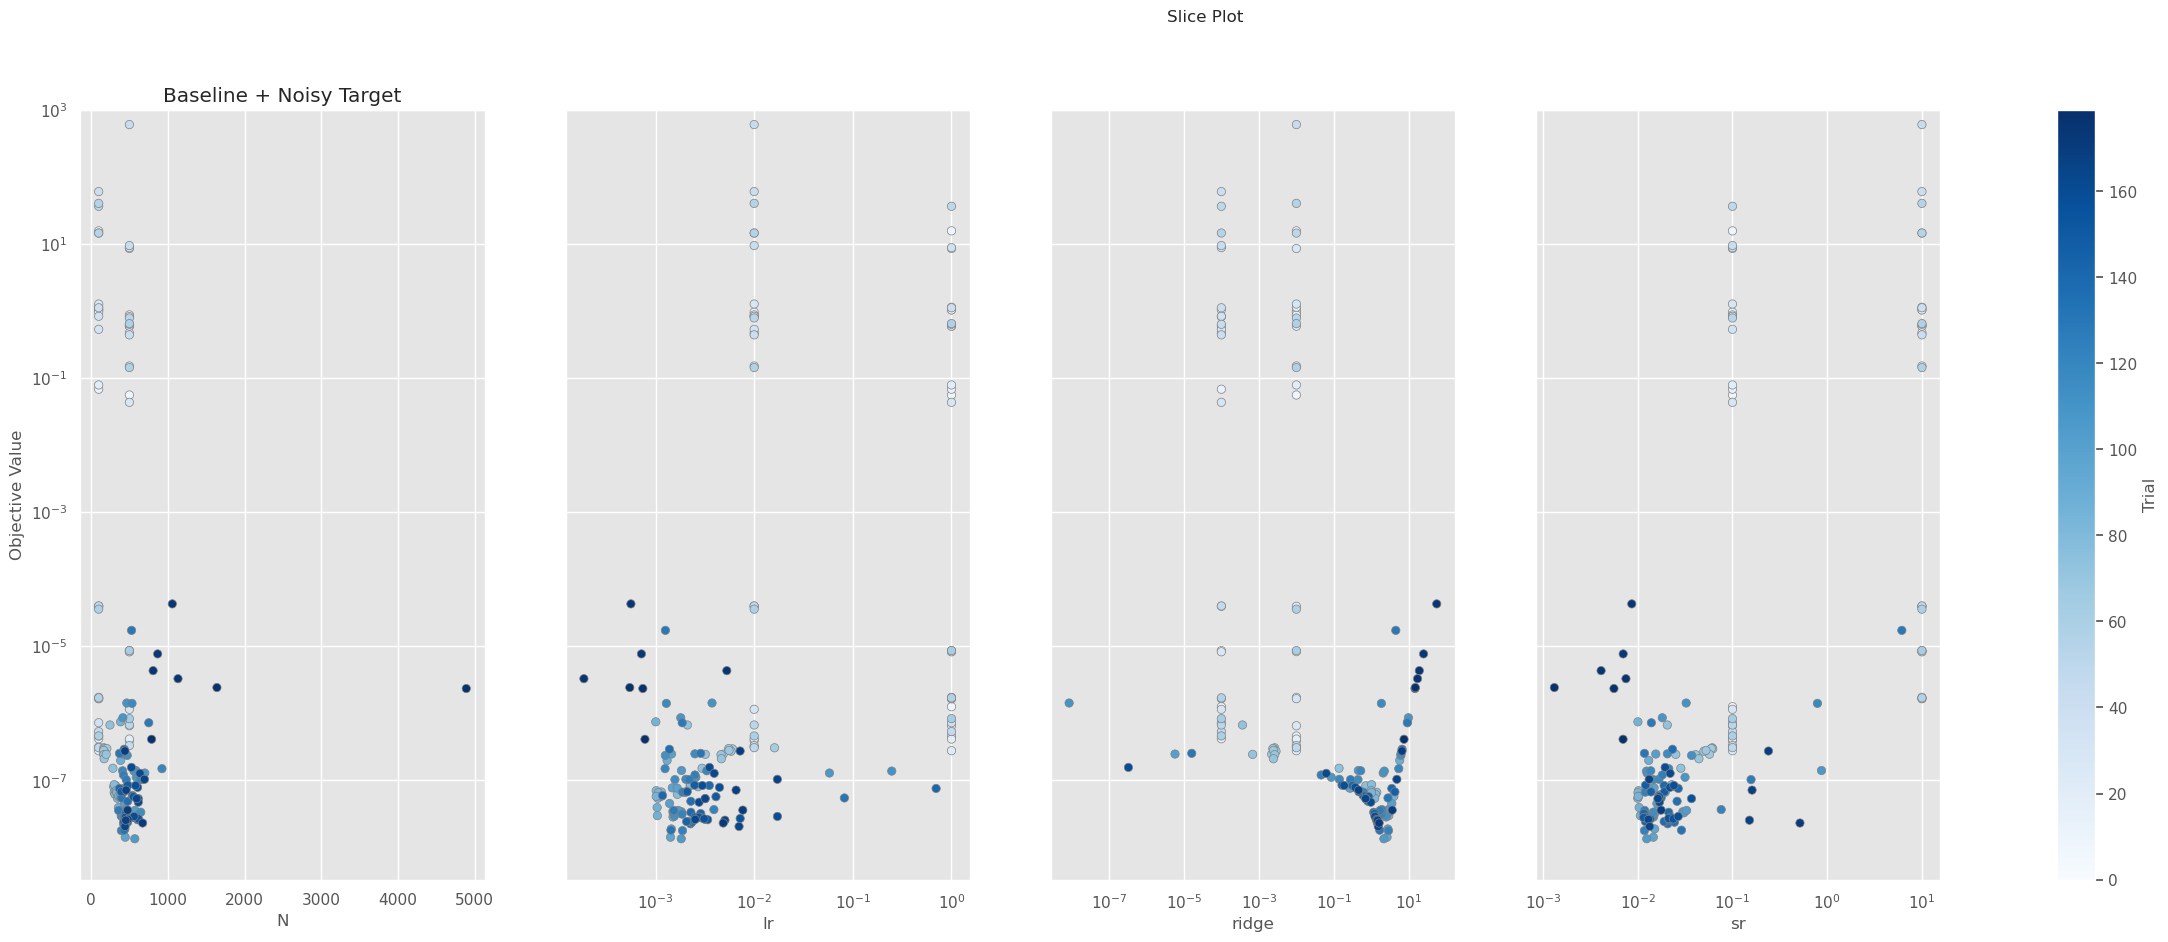

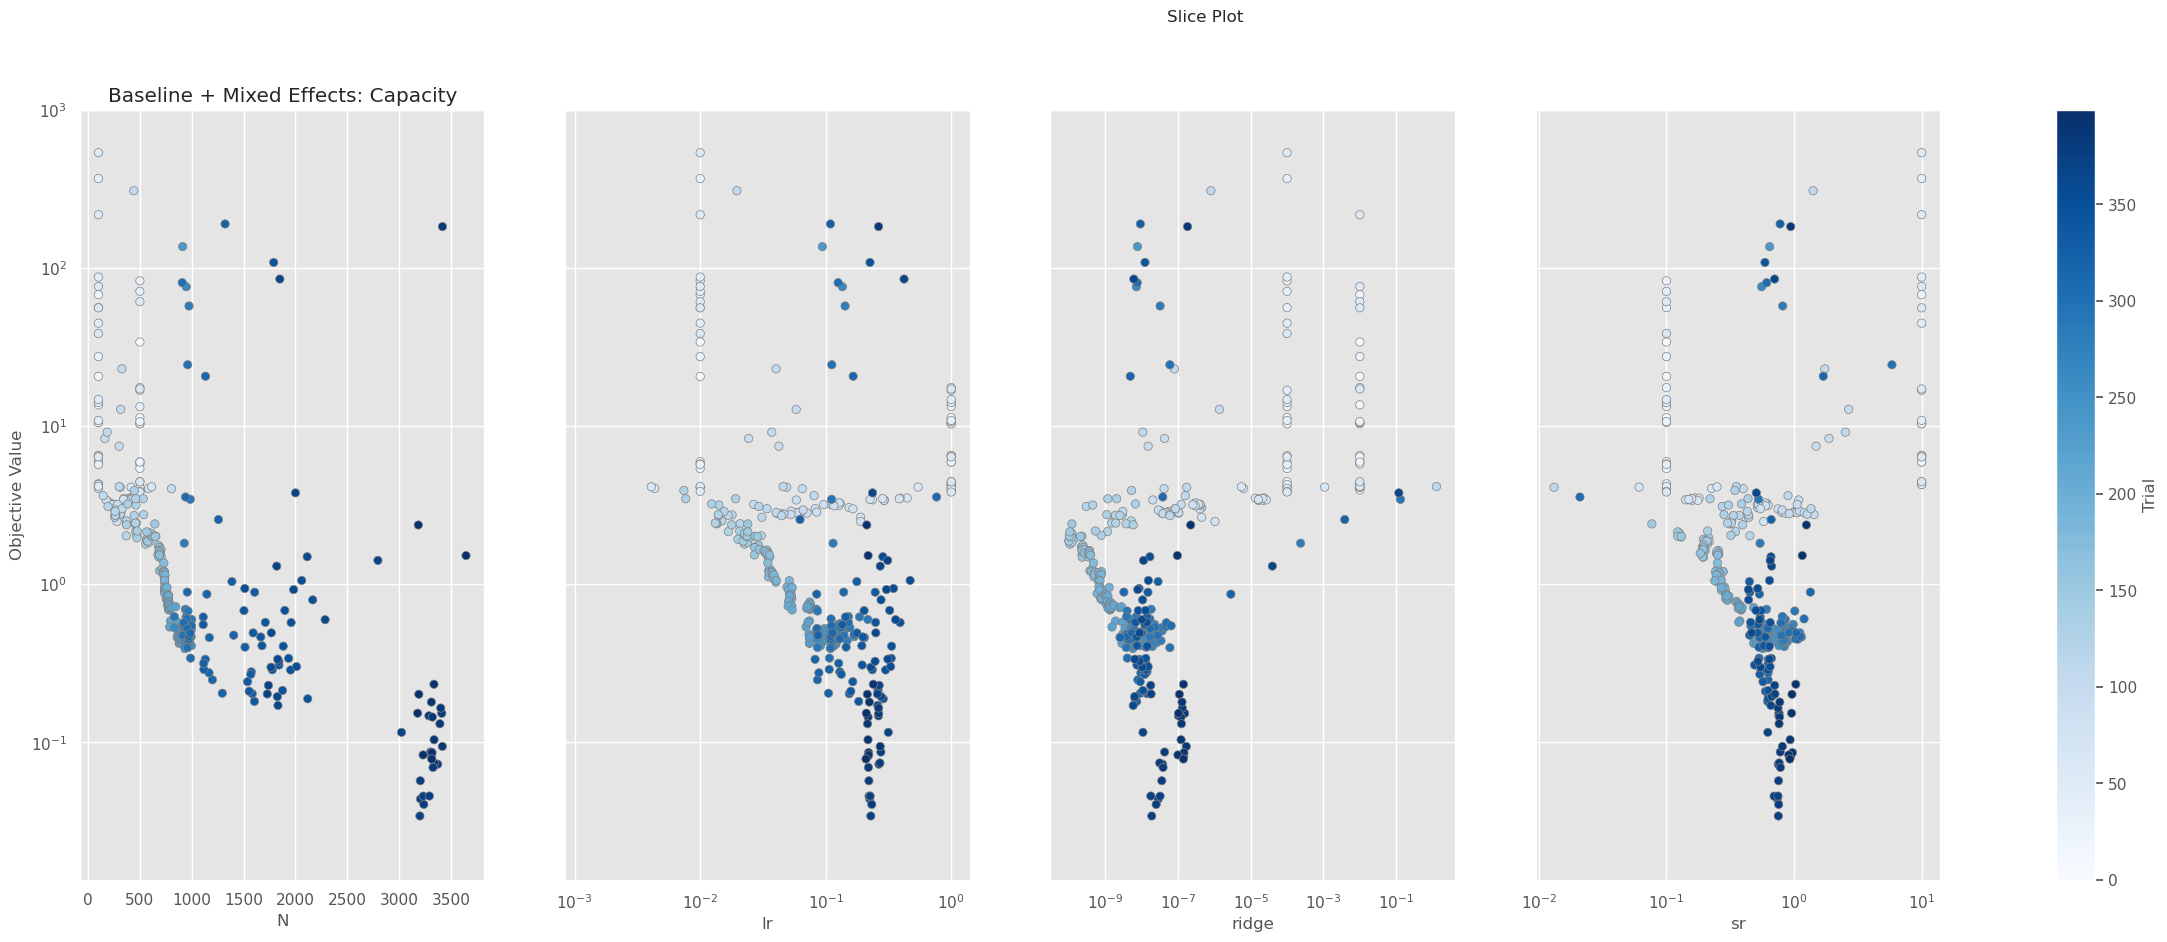

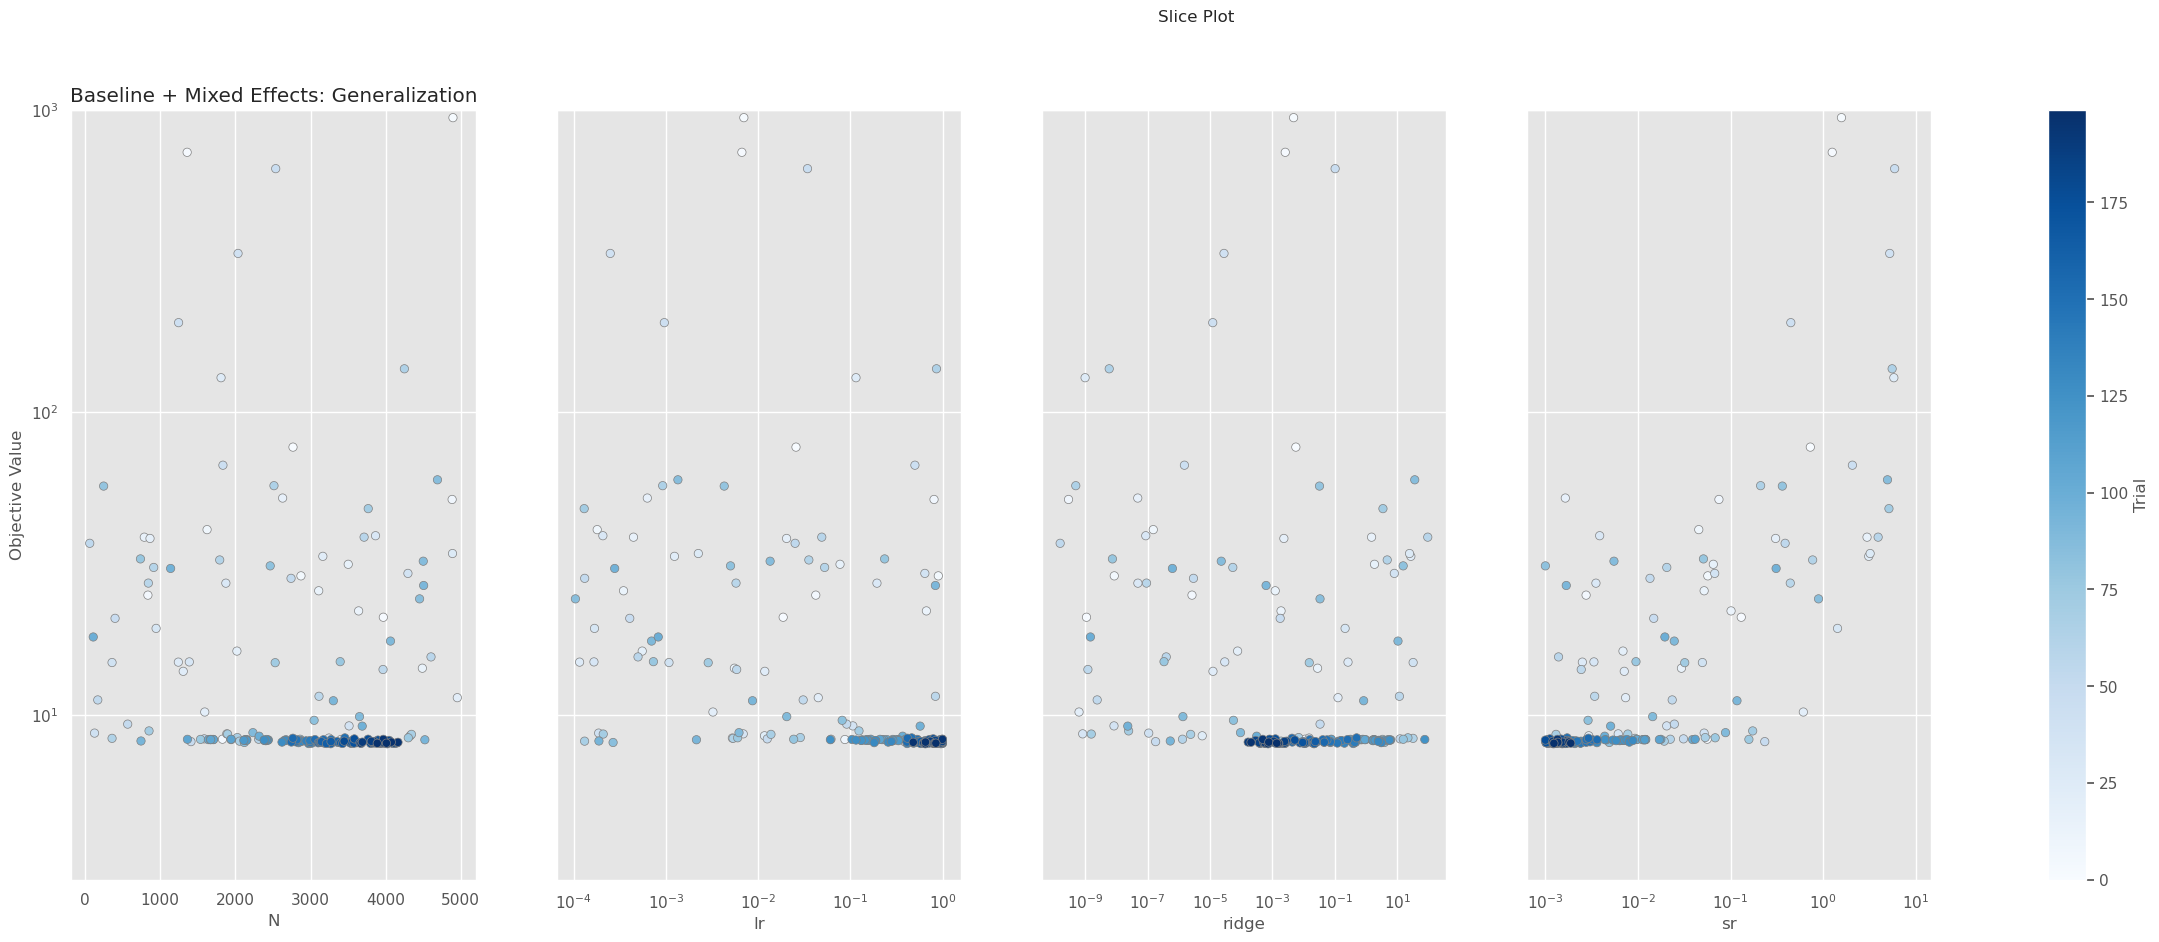

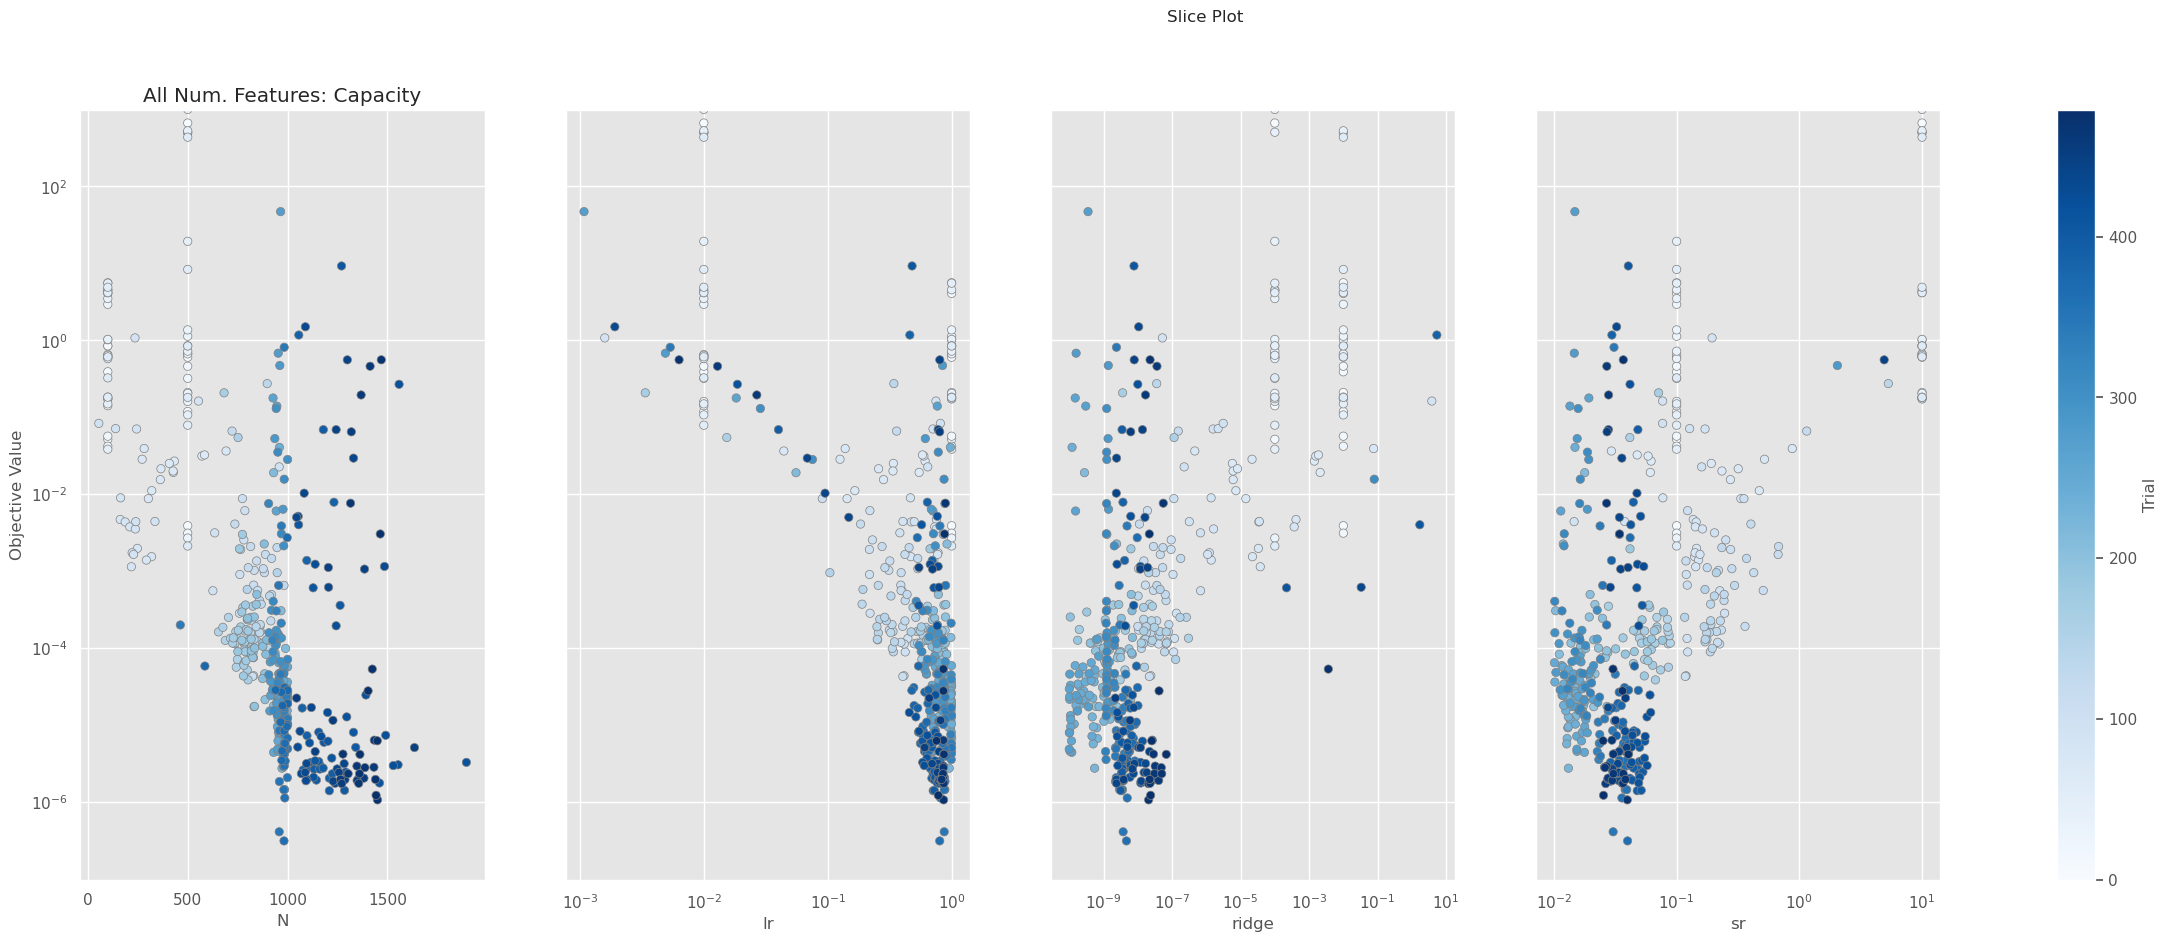

In [47]:
for title, study_name in studies_titles.items():

    db_name = f"{study_name}.db"
    df_name = f"{study_name}.pkl"
    storage_name = f"sqlite:///{db_name}"

    study = optuna.load_study(
        study_name=study_name,
        storage=storage_name,
    )

    axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
    ax = axes[0]
    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_ylim(top=1e3)